# Clustering Menopausal Users

Cluster symptoms from the users meeting the criteria for menopause.

User selection criteria - users have recorded more than 0 days of symptoms, that they've entered menopause, that they don't have periods anymore, and that they've not had chemo. 

In [195]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [196]:
from sensorfabric.athena import athena

In [197]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [198]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [199]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [200]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [201]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Original Query Isn't Great - Leaves in Some of the Wrong Folks

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            )
            AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%')
            
            AND (
            answers NOT LIKE '%Chemotherapy%'
            AND answers NOT LIKE 'Unpredictable'
            AND answers NOT LIKE 'Regular cycle'
            )
            OR answers NOT LIKE 'none'
        )
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(25577, 3)


uid           name  count
0  5f8f274466dae0d0328adb80       bloating      1
1  5f8f274466dae0d0328adb80      headaches      1
2  5f8f274466dae0d0328adb80  brittle_nails      1
3  5f90eb35a42cd9d7053ec1d5   constipation      1
4  5f90eb35a42cd9d7053ec1d5    hot_flashes      1

## Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months - Draw from symptompp_npt or symptompp_pot to get non product takers or product takers. Elsewise symptoms is all symptoms, symptompp removes some test users

In [202]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(33945, 3)


uid             name  count
0  5f92aeffa42cd9d7053ec1ff          anxiety      2
1  5f92aeffa42cd9d7053ec1ff          fatigue      2
2  5f92aeffa42cd9d7053ec1ff  vaginal_dryness      2
3  5f92aeffa42cd9d7053ec1ff         spotting      2
4  5f92aeffa42cd9d7053ec1ff        sex_drive      2

## Check the onboarding data of who actually showed up in the query

In [203]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(151306, 3)


In [173]:
menopausalusers_onboarding.to_csv('onboarding_menopausalnpt_check.csv')

In [204]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 2403


## Create Dataframe of Queried Data

In [205]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [206]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [207]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 2286


In [208]:
# Calculate the unique number of UIDs

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 2403


In [179]:
frame.to_csv('menopausalsymptomsnonpttest.csv')

In [209]:
frame.head()

anxiety  fatigue  vaginal_dryness  spotting  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff        2        2                2         2   
5f982c6344eca8ead4eca0c1        0        0                0         0   
5f98e88b44eca8ead4eca24c        0        1                0         0   
5f9935fa44eca8ead4eca26d        0        0                1         0   
5f99b73cb82e4d12e4a90a4d        1        0                0         0   

                          sex_drive  night_sweats  mood_swings  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff          2             2            2            2   
5f982c6344eca8ead4eca0c1          0             0            1           29   
5f98e88b44eca8ead4eca24c          0             1            0           83   
5f9935fa44eca8ead4eca26d          1             0            2            0   
5f99b73cb82e4d12e4a90a4d          1             1            1            1   

                          headaches  painful_intercourse  ...  \
uid                                                       ...   
5f92aeffa42cd9d7053ec1ff          2                    2  ...   
5f982c6344eca8ead4eca0c1          0                    0  ...   
5f98e88b44eca8ead4eca24c          0                    0  ...   
5f9935fa44eca8ead4eca26d          1                    0  ...   
5f99b73cb82e4d12e4a90a4d          1                    0  ...   

                          tingling_extremeties  yeast_infection  cramps  \
uid                                                                       
5f92aeffa42cd9d7053ec1ff                     0                0       0   
5f982c6344eca8ead4eca0c1                     0                0       0   
5f98e88b44eca8ead4eca24c                     0                0       0   
5f9935fa44eca8ead4eca26d                     0                0       0   
5f99b73cb82e4d12e4a90a4d                     0                0       0   

                          depression  breast_swelling  vertigo  odor  \
uid                                                                    
5f92aeffa42cd9d7053ec1ff           0                0        0     0   
5f982c6344eca8ead4eca0c1           0                0        0     0   
5f98e88b44eca8ead4eca24c           0                0        0     0   
5f9935fa44eca8ead4eca26d           0                0        0     0   
5f99b73cb82e4d12e4a90a4d           0                0        0     0   

                          incontinence  diarrhea  vomiting  
uid                                                         
5f92aeffa42cd9d7053ec1ff             0         0         0  
5f982c6344eca8ead4eca0c1             0         0         0  
5f98e88b44eca8ead4eca24c             0         0         0  
5f9935fa44eca8ead4eca26d             0         0         0  
5f99b73cb82e4d12e4a90a4d             0         0         0  

[5 rows x 45 columns]

In [211]:
frame=frame.astype(int)

In [212]:
data_type = frame[symptoms].dtypes

In [210]:
frame.shape

(2286, 45)

In [213]:
encoding = frame.copy(deep=True)

In [184]:
encoding

anxiety fatigue vaginal_dryness spotting sex_drive  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff       2       2               2        2         2   
5f982c6344eca8ead4eca0c1       0       0               0        0         0   
5f98e88b44eca8ead4eca24c       0       1               0        0         0   
5f9935fa44eca8ead4eca26d       0       0               1        0         1   
5f99b73cb82e4d12e4a90a4d       1       0               0        0         1   
...                          ...     ...             ...      ...       ...   
640f7cf44c33a20028c6102e       1       1               0        0         1   
640fa88a4c33a20028c610dd       1       0               0        0         0   
640fd8074c33a20028c61183       3       1               1        0         1   
64105b7e4c33a20028c6127f       0       0               0        0         0   
64219629df7eeb0028d604cf       1       1               0        0         1   

                         night_sweats mood_swings hot_flashes headaches  \
uid                                                                       
5f92aeffa42cd9d7053ec1ff            2           2           2         2   
5f982c6344eca8ead4eca0c1            0           1          29         0   
5f98e88b44eca8ead4eca24c            1           0          83         0   
5f9935fa44eca8ead4eca26d            0           2           0         1   
5f99b73cb82e4d12e4a90a4d            1           1           1         1   
...                               ...         ...         ...       ...   
640f7cf44c33a20028c6102e            1           0           1         0   
640fa88a4c33a20028c610dd            1           1           1         0   
640fd8074c33a20028c61183            0           2           2         2   
64105b7e4c33a20028c6127f            0           1          73         8   
64219629df7eeb0028d604cf            1           1           0         0   

                         painful_intercourse  ... tingling_extremeties  \
uid                                           ...                        
5f92aeffa42cd9d7053ec1ff                   2  ...                    0   
5f982c6344eca8ead4eca0c1                   0  ...                    0   
5f98e88b44eca8ead4eca24c                   0  ...                    0   
5f9935fa44eca8ead4eca26d                   0  ...                    0   
5f99b73cb82e4d12e4a90a4d                   0  ...                    0   
...                                      ...  ...                  ...   
640f7cf44c33a20028c6102e                   0  ...                    0   
640fa88a4c33a20028c610dd                   0  ...                    0   
640fd8074c33a20028c61183                   1  ...                    0   
64105b7e4c33a20028c6127f                   0  ...                    0   
64219629df7eeb0028d604cf                   0  ...                    0   

                         yeast_infection cramps depression breast_swelling  \
uid                                                                          
5f92aeffa42cd9d7053ec1ff               0      0          0               0   
5f982c6344eca8ead4eca0c1               0      0          0               0   
5f98e88b44eca8ead4eca24c               0      0          0               0   
5f9935fa44eca8ead4eca26d               0      0          0               0   
5f99b73cb82e4d12e4a90a4d               0      0          0               0   
...                                  ...    ...        ...             ...   
640f7cf44c33a20028c6102e               0      0          0               0   
640fa88a4c33a20028c610dd               0      0          1               0   
640fd8074c33a20028c61183               0      0          2               1   
64105b7e4c33a20028c6127f               0      0          1               0   
64219629df7eeb0028d604cf               0      0          1               0   

                         vertigo odor incon

In [214]:
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0

In [215]:
encoding = encoding.applymap(replace_map)

In [217]:
# Save this into a csv file so we can use it from inside R.
encoding.to_csv('symptoms_menopause_npt_onehot.csv', index=False)

In [218]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count = frame.sum().sum()
print("Total count of all symptoms:", total_symptom_count)


Total count of all symptoms: 61806


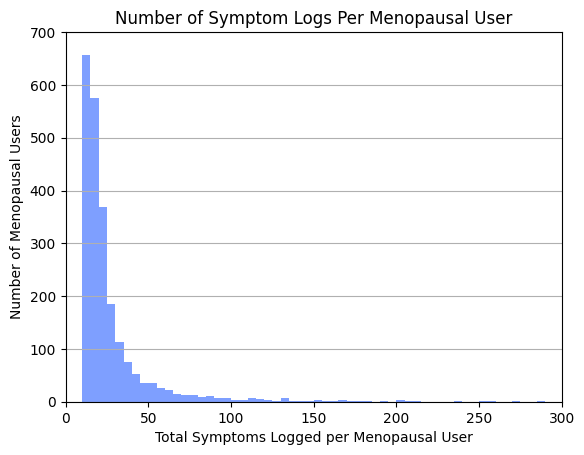

Median Symptoms per User: 19.0
Median Absolute Deviation (MAD) of Symptoms per User: 6.0


In [234]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = frame.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7, color=(72/255, 118/255, 255/255))
plt.xlabel('Total Symptoms Logged per Menopausal User')
plt.ylabel('Number of Menopausal Users')
plt.title('Number of Symptom Logs Per Menopausal User')
plt.grid(axis='y')
plt.ylim(0,700) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)

In [235]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 22.25%
fatigue: 5.13%
night_sweats: 4.31%
anxiety: 3.96%
joint_pain: 3.52%
bloating: 3.45%
brain_fog: 3.42%
headaches: 3.07%
insomnia: 2.93%
dry_skin: 2.85%
mood_swings: 2.70%
depression: 2.63%
allergies: 2.53%
dry_eyes: 2.43%
muscle_tension: 2.41%
brittle_nails: 2.21%
itchy_skin: 2.12%
facial_hair: 2.10%
sex_drive: 2.08%
memory_lapse: 2.04%
hair_loss: 1.72%
constipation: 1.66%
ringing_ears: 1.48%
dizzy: 1.47%
tingling_extremeties: 1.47%
vaginal_dryness: 1.45%
incontinence: 1.41%
chills: 1.36%
heartburn: 1.27%
breast_pain: 1.07%
nausea: 1.03%
irregular_beat: 1.02%
odor: 0.87%
cramps: 0.86%
diarrhea: 0.83%
painful_intercourse: 0.68%
vertigo: 0.59%
breast_swelling: 0.48%
uti: 0.37%
spotting: 0.36%
yeast_infection: 0.24%
vomiting: 0.10%
nipple_discharge: 0.09%
ovulation_pain: 0.00%
ovulation: 0.00%


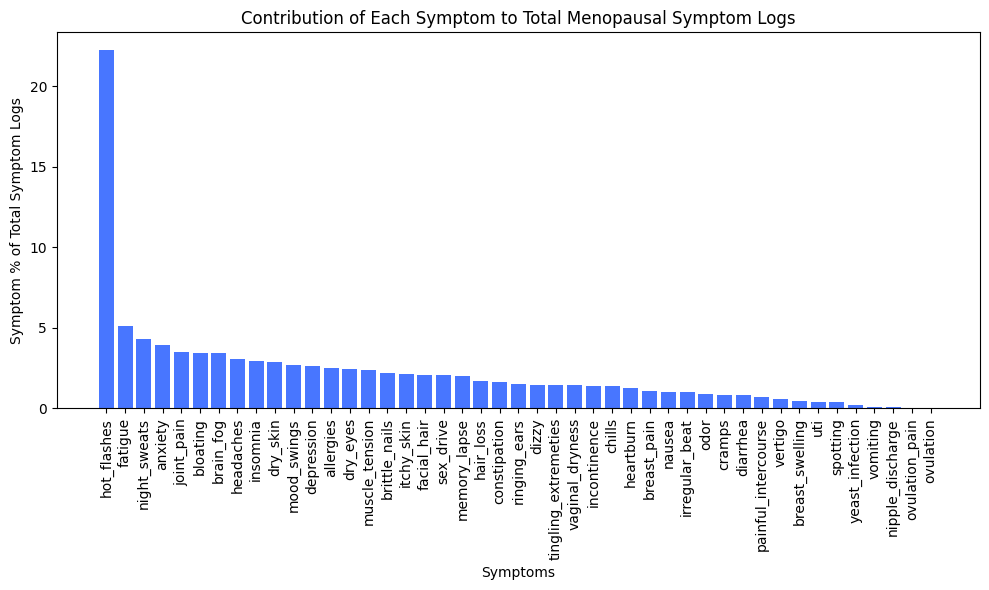

In [239]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
bars = plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values, color=(72/255, 118/255, 255/255))
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Menopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels

# Add percentage labels above the bars
#for bar, percentage in zip(bars, symptom_percentages_sorted.values):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

In [240]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 74.978128
hot_flashes             73.097113
anxiety                 58.748906
joint_pain              56.124234
brain_fog               56.124234
night_sweats            53.280840
bloating                52.405949
insomnia                52.055993
mood_swings             49.037620
headaches               48.862642
dry_skin                47.462817
depression              47.112861
memory_lapse            43.000875
sex_drive               41.557305
muscle_tension          40.682415
itchy_skin              39.238845
brittle_nails           38.976378
facial_hair             37.051619
allergies               36.789151
dry_eyes                35.389326
hair_loss               34.820647
constipation            32.370954
tingling_extremeties    28.958880
vaginal_dryness         27.996500
dizzy                   27.121610
incontinence            24.759405
ringing_ears            24.759405
heartburn               23.490814
irregular_beat          20.822397
chills        

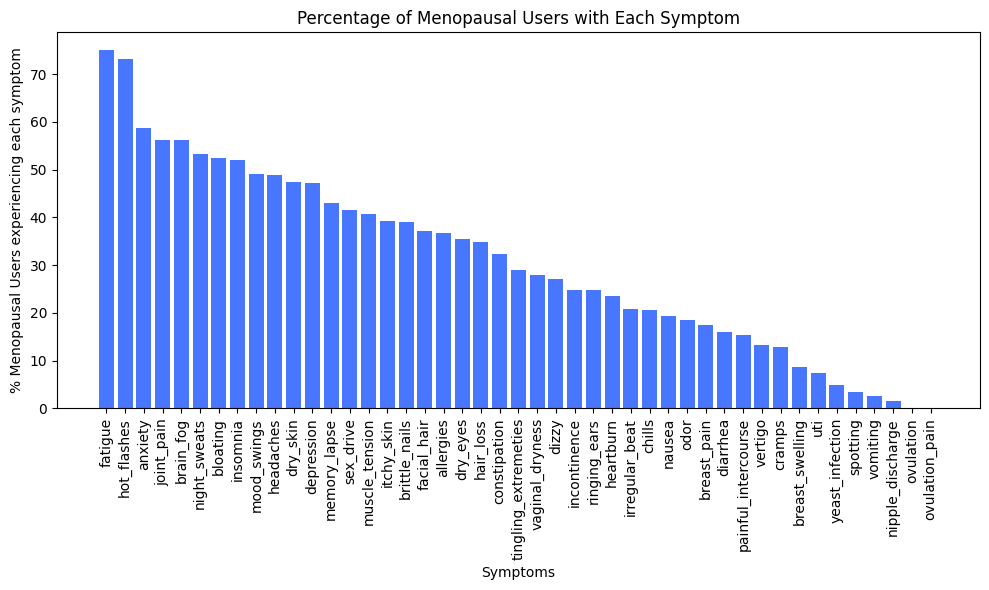

In [243]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(72/255, 118/255, 255/255))
plt.xlabel("Symptoms")
plt.ylabel("% Menopausal Users experiencing each symptom")
plt.title("Percentage of Menopausal Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [244]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



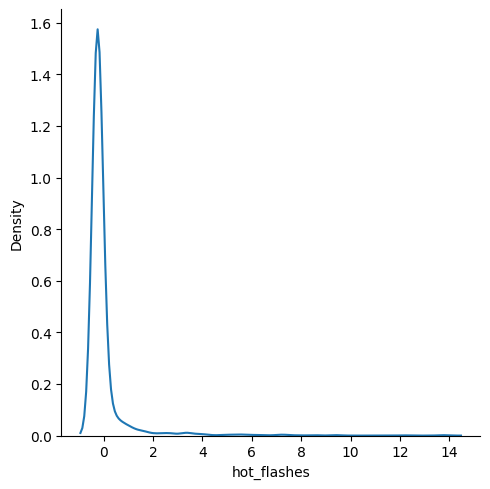

In [245]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



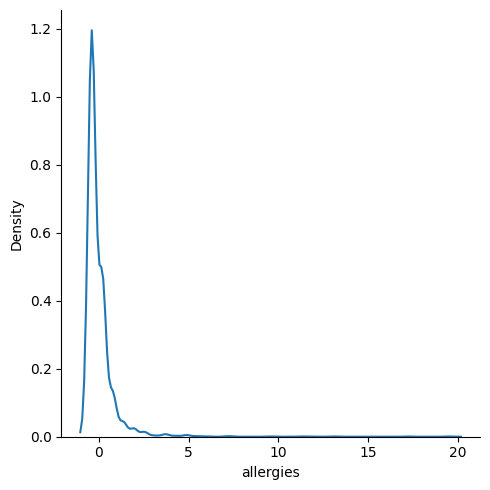

In [246]:
sns.displot(sframe, x='allergies', kind='kde')

In [247]:
cmatrix = sframe.cov()

In [248]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [249]:
cmatrix.to_csv('menopause_symptom_npt_covariance.csv', index=True)

In [250]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('menopause_symptom_npt_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

In [252]:
th = 0.4
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

anxiety - depression - 0.444640825821124
brain_fog - fatigue - 0.4973623246047882
brain_fog - memory_lapse - 0.496311062768582
brittle_nails - dry_skin - 0.46704958073484826
chills - irregular_beat - 0.4535375495150016
depression - anxiety - 0.444640825821124
dry_eyes - dry_skin - 0.5019403590433281
dry_skin - brittle_nails - 0.46704958073484826
dry_skin - dry_eyes - 0.5019403590433281
dry_skin - itchy_skin - 0.4388091741193365
facial_hair - itchy_skin - 0.4969249466142075
facial_hair - vaginal_dryness - 0.4612143972510855
fatigue - brain_fog - 0.4973623246047882
fatigue - headaches - 0.42646234885074186
headaches - fatigue - 0.42646234885074186
irregular_beat - chills - 0.4535375495150016
itchy_skin - dry_skin - 0.4388091741193365
itchy_skin - facial_hair - 0.4969249466142075
itchy_skin - vaginal_dryness - 0.46522064534945634
joint_pain - muscle_tension - 0.4280727330568861
memory_lapse - brain_fog - 0.496311062768582
memory_lapse - muscle_tension - 0.4096439211338576
muscle_tension -

## Cluster Map

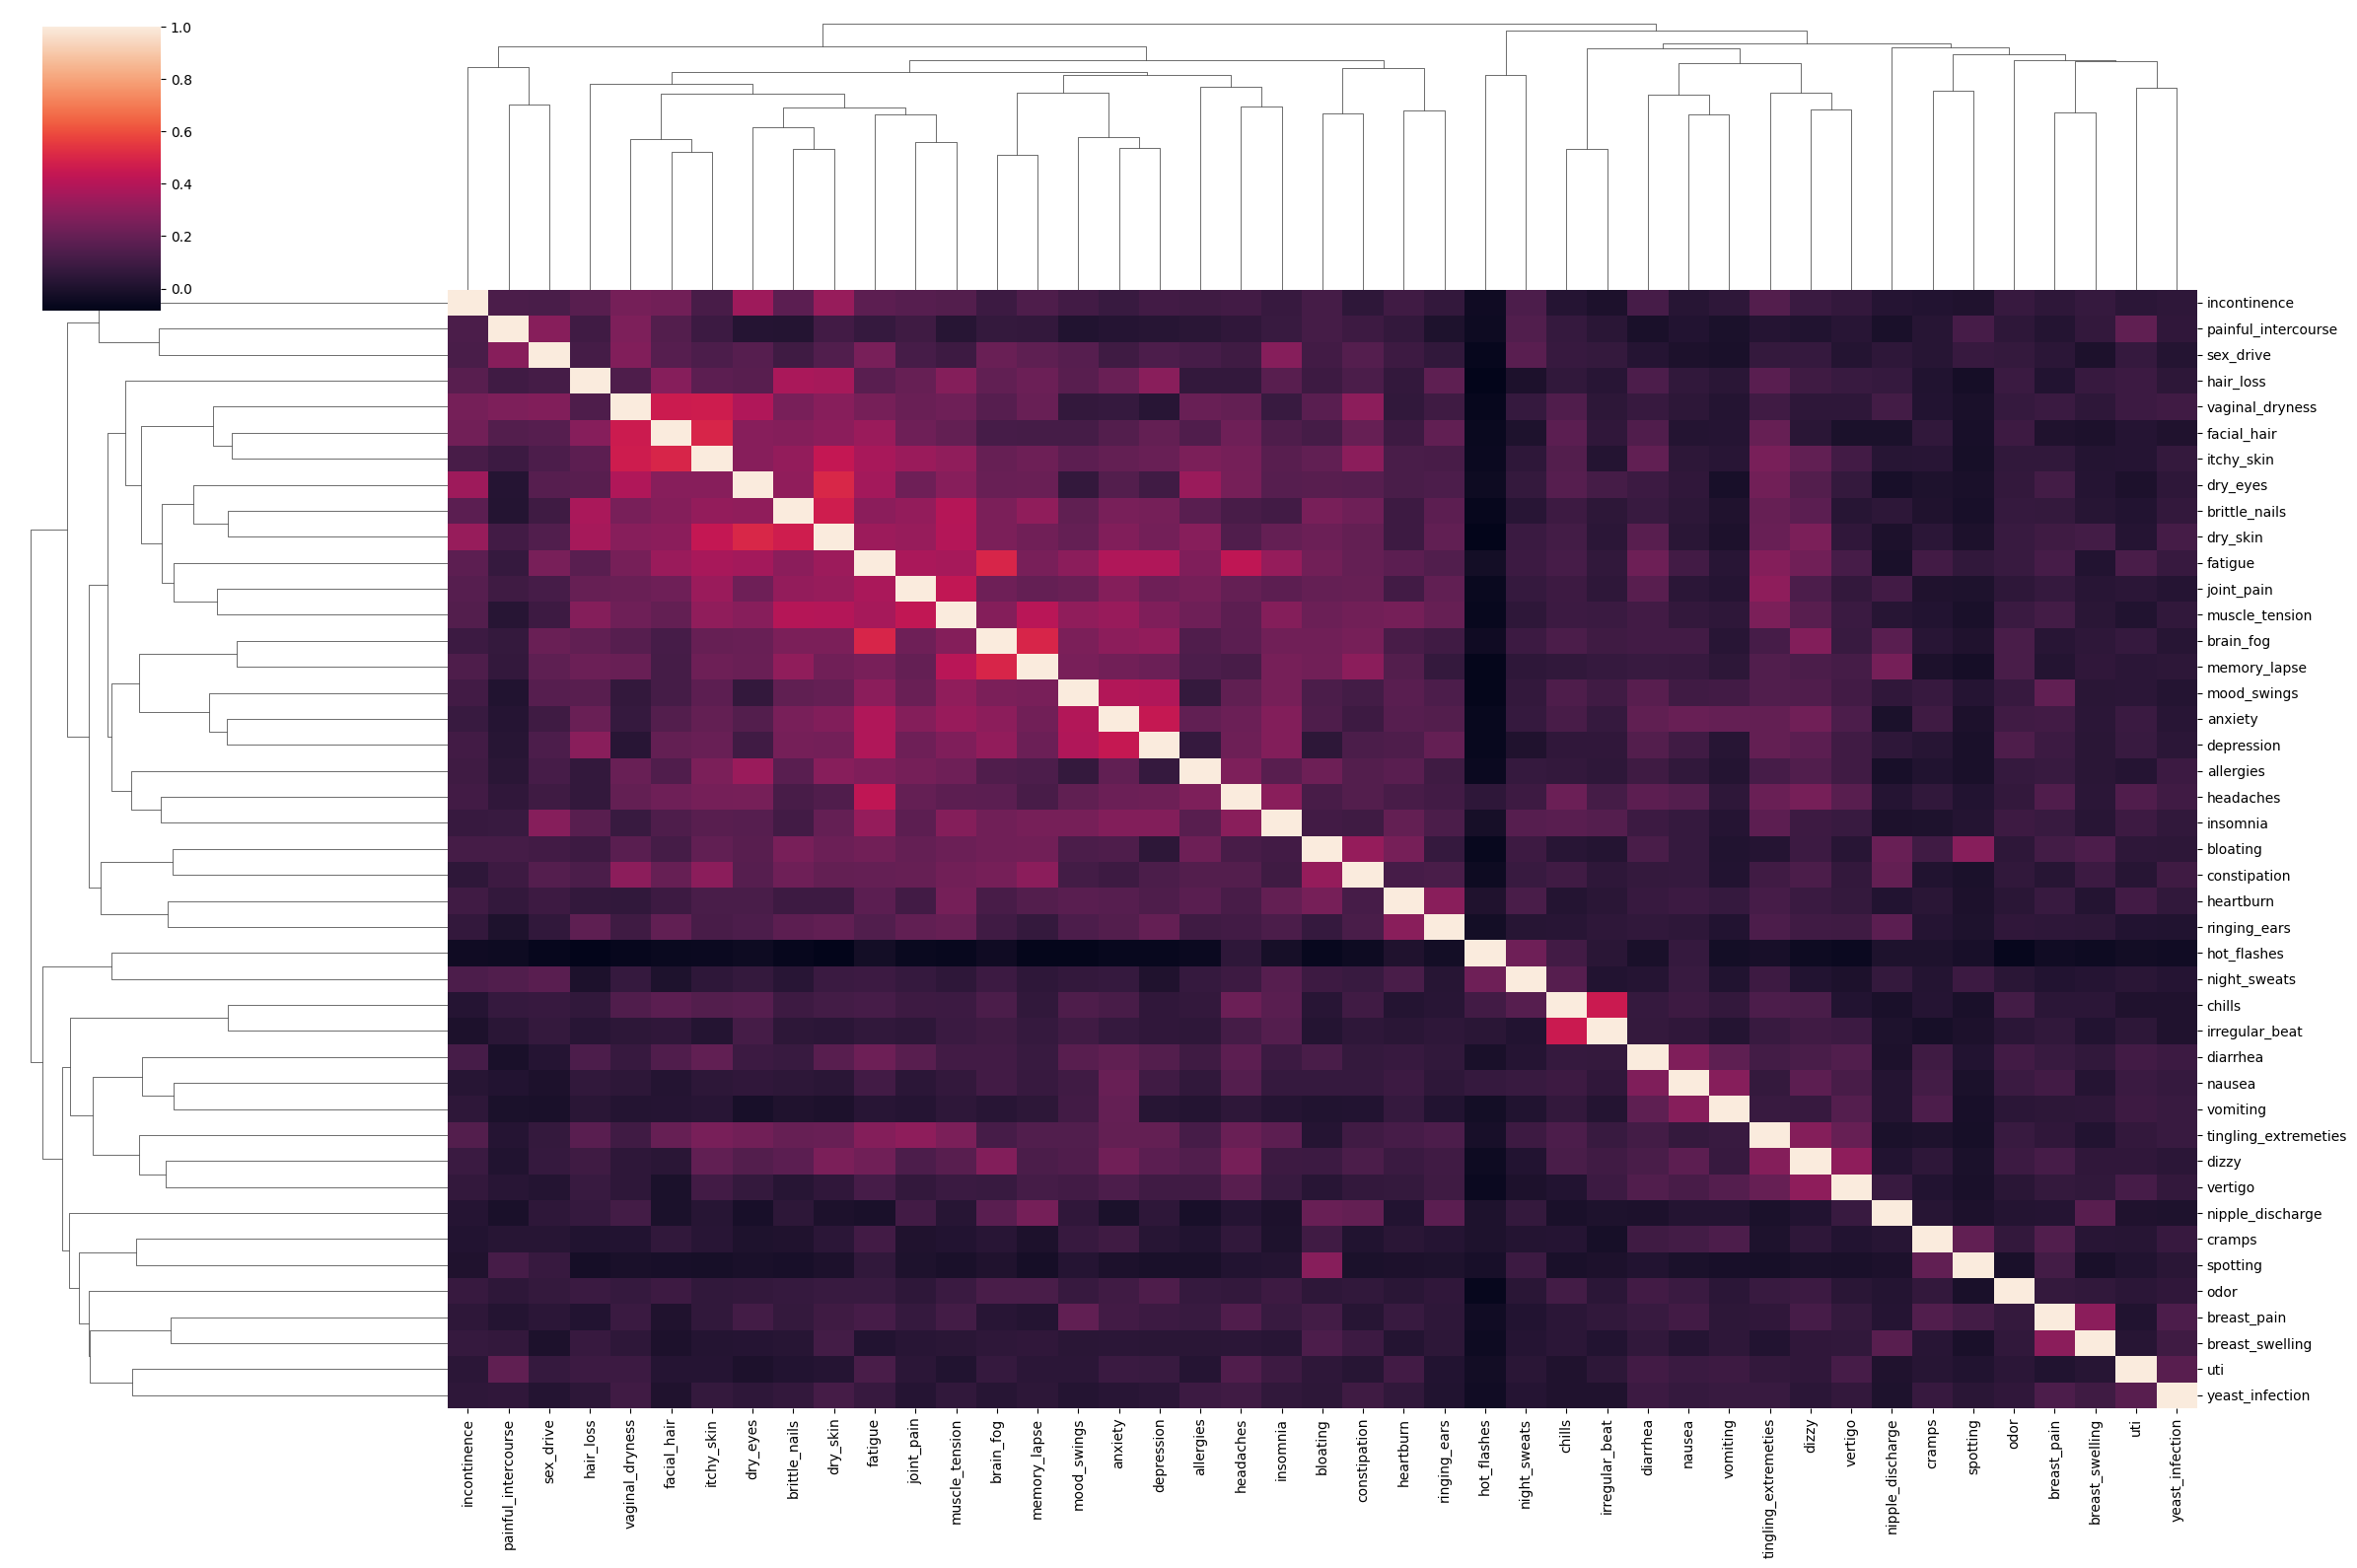

In [253]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [254]:
hcluster.savefig('symptom_co_hirach_menopausal_npt.png')

In [255]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [256]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 2


## Perform PCA analysis on the data.

In [257]:
from sklearn.decomposition import PCA

In [258]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [259]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [260]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [261]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.86, 0.86
PCA2 - 0.03, 0.89
PCA3 - 0.02, 0.91
PCA4 - 0.01, 0.92
PCA5 - 0.01, 0.92
PCA6 - 0.01, 0.93
PCA7 - 0.01, 0.94
PCA8 - 0.00, 0.94
PCA9 - 0.00, 0.94
PCA10 - 0.00, 0.95
PCA11 - 0.00, 0.95
PCA12 - 0.00, 0.96
PCA13 - 0.00, 0.96
PCA14 - 0.00, 0.96
PCA15 - 0.00, 0.97


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (89%).

In [262]:
pcacomponents = pca.fit_transform(X)

In [263]:
pcacomponents.shape

(2286, 15)

In [264]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [265]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

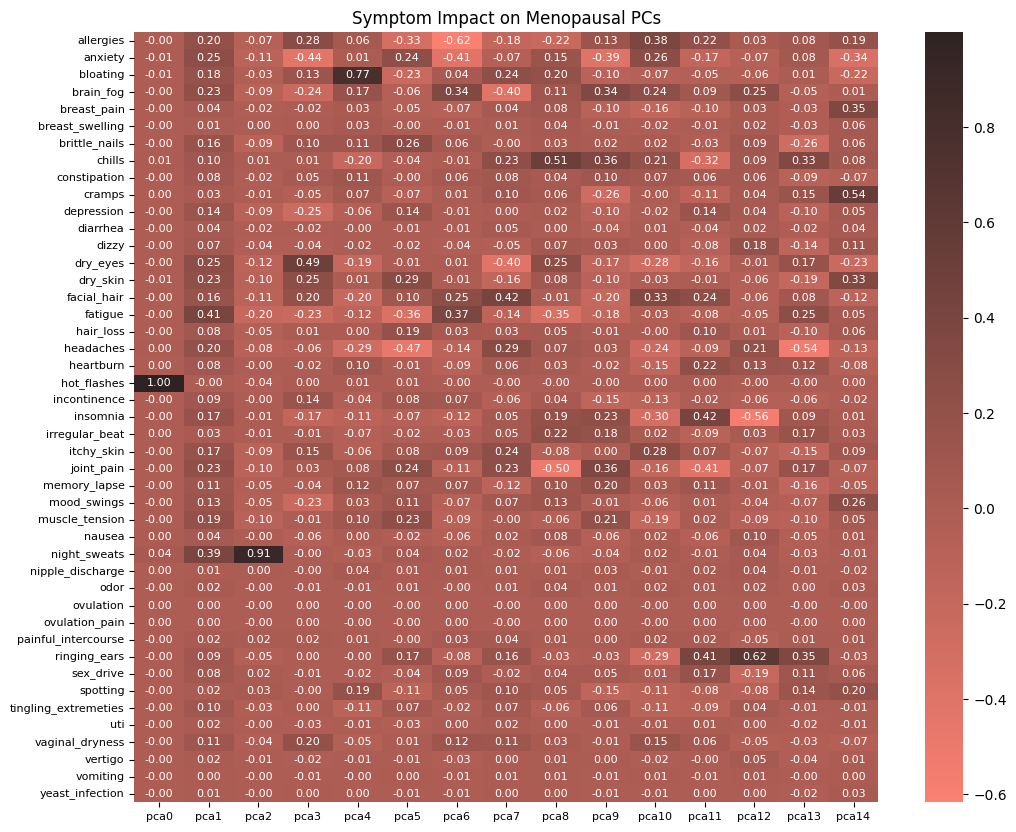

In [283]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Create a light palette with the color 'seagreen'
cmap=sns.color_palette("dark:salmon_r", as_cmap=True)

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap=cmap, annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 90% variance

In [267]:
pca = PCA(n_components=3, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(2286, 3)

In [268]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [269]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

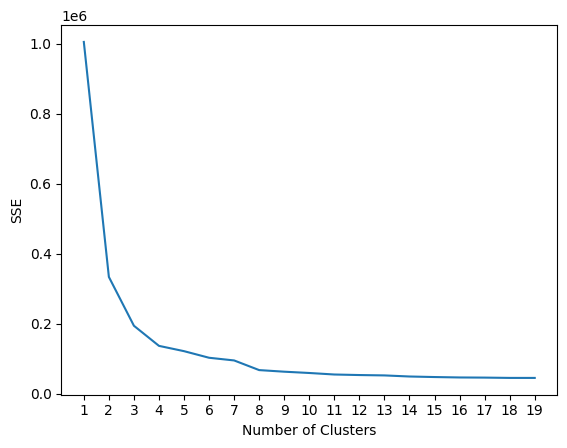

In [270]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [271]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **4**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [273]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

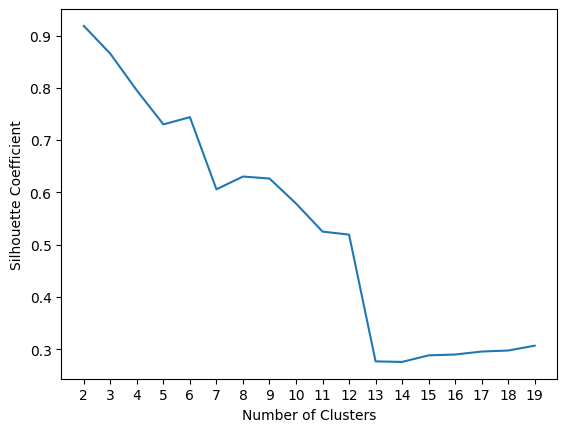

In [274]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [276]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 49
1 - 137
2 - 16
3 - 2084


## Get the users which belong to each of these clusters

In [277]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [278]:
def getTopSymptoms(users, top=5):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [280]:
## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [281]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [282]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['hot_flashes' 'night_sweats' 'chills' 'headaches' 'irregular_beat']
Segment 1
['hot_flashes' 'night_sweats' 'fatigue' 'brain_fog' 'bloating']
Segment 2
['hot_flashes' 'night_sweats' 'headaches' 'fatigue' 'insomnia']
Segment 3
['hot_flashes' 'fatigue' 'anxiety' 'joint_pain' 'bloating']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 20
1 - 3335
2 - 114
Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']
Segment 1
['hot_flashes' 'fatigue' 'joint_pain' 'bloating' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'joint_pain' 'fatigue' 'allergies']


In [ ]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
from sensorfabric.athena import athena

In [ ]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [ ]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [ ]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [ ]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [ ]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Original Query Isn't Great - Leaves in Some of the Wrong Folks

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            )
            AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%')
            
            AND (
            answers NOT LIKE '%Chemotherapy%'
            AND answers NOT LIKE 'Unpredictable'
            AND answers NOT LIKE 'Regular cycle'
            )
            OR answers NOT LIKE 'none'
        )
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(25577, 3)


uid           name  count
0  5f8f274466dae0d0328adb80       bloating      1
1  5f8f274466dae0d0328adb80      headaches      1
2  5f8f274466dae0d0328adb80  brittle_nails      1
3  5f90eb35a42cd9d7053ec1d5   constipation      1
4  5f90eb35a42cd9d7053ec1d5    hot_flashes      1

## Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(51271, 3)


uid                 name  count
0  5f92aeffa42cd9d7053ec1ff  painful_intercourse      2
1  5f92aeffa42cd9d7053ec1ff              anxiety      2
2  5f92aeffa42cd9d7053ec1ff              fatigue      2
3  5f92aeffa42cd9d7053ec1ff             spotting      2
4  5f92aeffa42cd9d7053ec1ff                  uti      2

## Check the onboarding data of who actually showed up in the query

In [ ]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >2
        and symptoms_recorded <500
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(313517, 3)


In [ ]:
menopausalusers_onboarding.to_csv('onboarding_menopausal_check.csv')

In [ ]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3628


## Create Dataframe of Queried Data

In [ ]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [ ]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [ ]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 3469


In [ ]:
# Calculate the unique number of UIDs

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3628


In [ ]:
frame.to_csv('menopausalsymptomstest.csv')

In [ ]:
frame.head()

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                0        0                0     0   
5f93fc6ea42cd9d7053ec24b                0        0                0     0   
5f9605bea42cd9d7053ec2bb                0        0                0     0   
5f97799144eca8ead4eca01f                0        0                0     0   
5f982c6344eca8ead4eca0c1                0        0                0     0   

                          vomiting  
uid                                 
5f92aeffa42cd9d7053ec1ff         0  
5f93fc6ea42cd9d7053ec24b         0  
5f9605bea42cd9d7053ec2bb         0  
5f97799144eca8ead4eca01f         0  
5f982c6344eca8ead4eca0c1         0  

[5 rows x 45 columns]

In [ ]:
frame.shape

(3469, 45)

In [ ]:
encoding = frame.copy(deep=True)

In [ ]:
encoding

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   
...                                       ...      ...      ...       ...   
640f7cf44c33a20028c6102e                    0        1        1         0   
640fa88a4c33a20028c610dd                    0        1        0         0   
640fd8074c33a20028c61183                    1        3        1         0   
64105b7e4c33a20028c6127f                    0        0        0         0   
64219629df7eeb0028d604cf                    0        1        1         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   
...                       ...        ...       ...         ...          ...   
640f7cf44c33a20028c6102e    0          1         1           0            1   
640fa88a4c33a20028c610dd    0          0         1           0            1   
640fd8074c33a20028c61183    0          1         2           1            2   
64105b7e4c33a20028c6127f    0          0         0           0           73   
64219629df7eeb0028d604cf    0          1         0           0            0   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   
...                               ...  ...     ...           ...   
640f7cf44c33a20028c6102e            0  ...       0             0   
640fa88a4c33a20028c610dd            1  ...       0             1   
640fd8074c33a20028c61183            2  ...       0             0   
64105b7e4c33a20028c6127f            1  ...       0             0   
64219629df7eeb0028d604cf            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   
...                                  ...               ...        ...   
640f7cf44c33a20028c6102e               1                 0          0   
640fa88a4c33a20028c610dd               0                 0          0   
640fd8074c33a20028c61183               1                 0          0   
64105b7e4c33a20028c6127f               0                 0          0   
64219629df7eeb0028d604cf               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aef

In [ ]:
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0

In [ ]:
encoding = encoding.applymap(replace_map)

In [ ]:
# Save this into a csv file so we can use it from inside R.
encoding.to_csv('csv/symptoms_menopause_onehot.csv', index=False)

In [ ]:
frame=frame.astype(int)

In [ ]:
data_type = frame[symptoms].dtypes

In [ ]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count = frame.sum().sum()
print("Total count of all symptoms:", total_symptom_count)


Total count of all symptoms: 115477


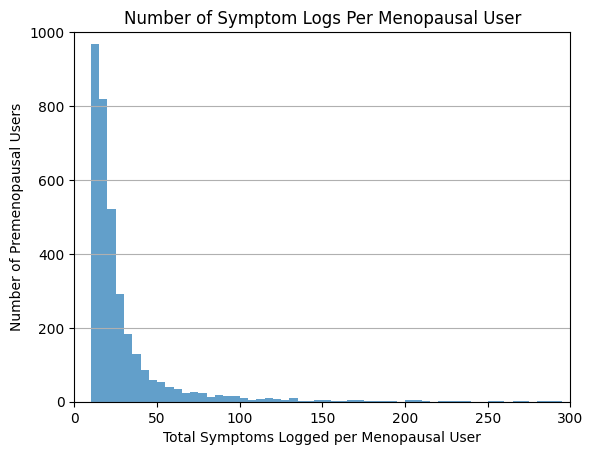

Median Symptoms per User: 19.0
Median Absolute Deviation (MAD) of Symptoms per User: 6.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = frame.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7)
plt.xlabel('Total Symptoms Logged per Menopausal User')
plt.ylabel('Number of Premenopausal Users')
plt.title('Number of Symptom Logs Per Menopausal User')
plt.grid(axis='y')
plt.ylim(0,1000) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)

In [ ]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 23.56%
fatigue: 5.21%
night_sweats: 5.18%
joint_pain: 4.39%
anxiety: 3.74%
bloating: 3.68%
brain_fog: 3.35%
headaches: 3.10%
allergies: 3.06%
dry_skin: 3.05%
insomnia: 2.77%
muscle_tension: 2.58%
dry_eyes: 2.39%
brittle_nails: 2.35%
depression: 2.27%
mood_swings: 2.24%
itchy_skin: 1.95%
facial_hair: 1.91%
sex_drive: 1.89%
memory_lapse: 1.70%
hair_loss: 1.62%
constipation: 1.60%
ringing_ears: 1.42%
tingling_extremeties: 1.41%
vaginal_dryness: 1.40%
chills: 1.35%
incontinence: 1.26%
dizzy: 1.25%
heartburn: 1.11%
breast_pain: 0.91%
irregular_beat: 0.89%
nausea: 0.82%
diarrhea: 0.76%
odor: 0.75%
cramps: 0.62%
painful_intercourse: 0.59%
breast_swelling: 0.46%
vertigo: 0.46%
uti: 0.29%
spotting: 0.29%
yeast_infection: 0.19%
vomiting: 0.08%
nipple_discharge: 0.07%
ovulation_pain: 0.00%
ovulation: 0.00%


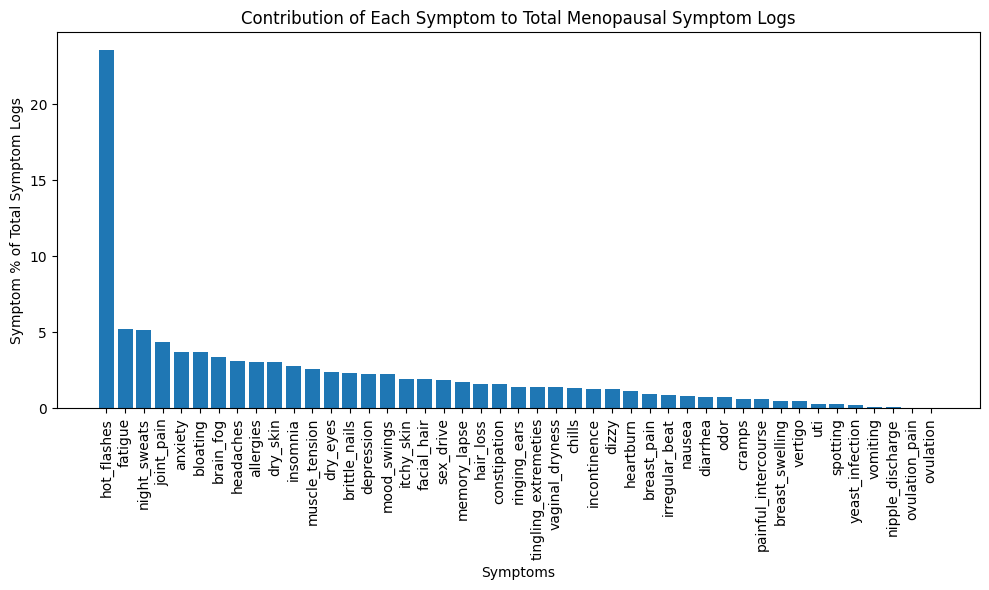

In [ ]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Menopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [ ]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 75.151340
hot_flashes             73.882963
joint_pain              57.480542
anxiety                 57.422888
bloating                56.615739
brain_fog               56.269818
night_sweats            54.338426
insomnia                52.205246
headaches               49.034304
dry_skin                48.169501
mood_swings             46.785817
depression              44.393197
memory_lapse            42.750072
sex_drive               42.029403
brittle_nails           40.530412
muscle_tension          40.299798
allergies               39.694436
itchy_skin              38.541366
facial_hair             37.186509
dry_eyes                36.523494
hair_loss               34.793889
constipation            33.381378
vaginal_dryness         28.769098
tingling_extremeties    28.653791
dizzy                   26.520611
ringing_ears            23.955030
incontinence            23.897377
heartburn               23.724416
chills                  20.611127
irregular_beat

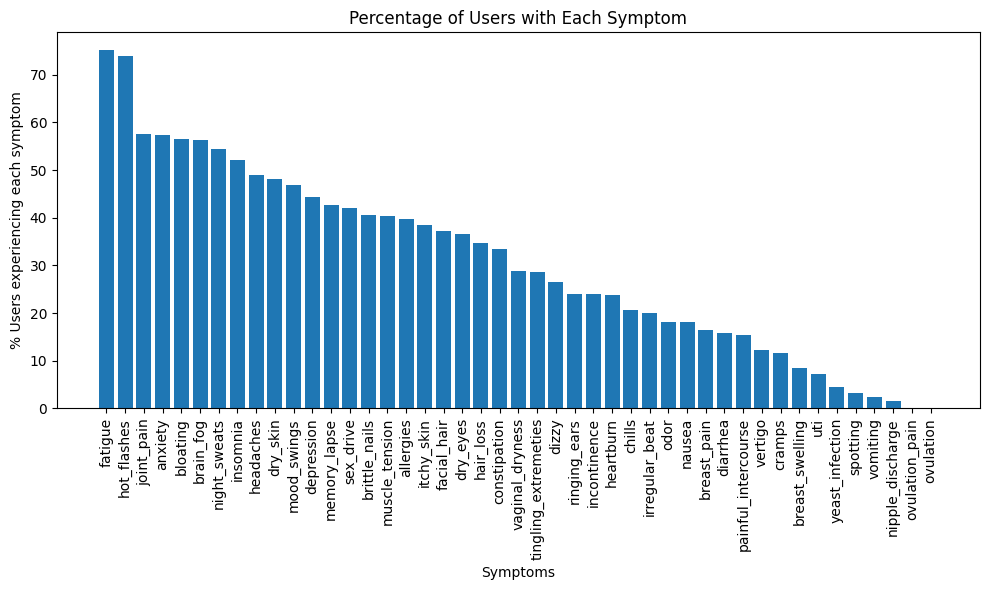

In [ ]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [ ]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


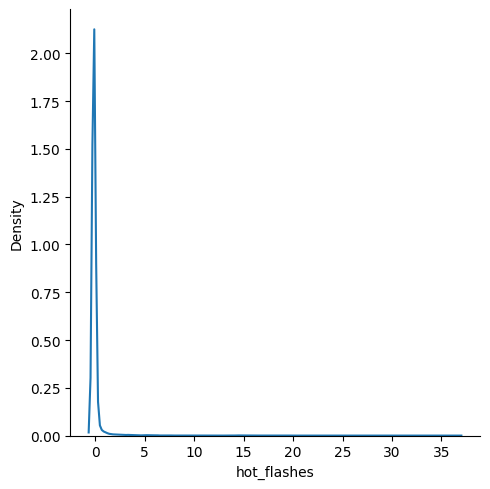

In [ ]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


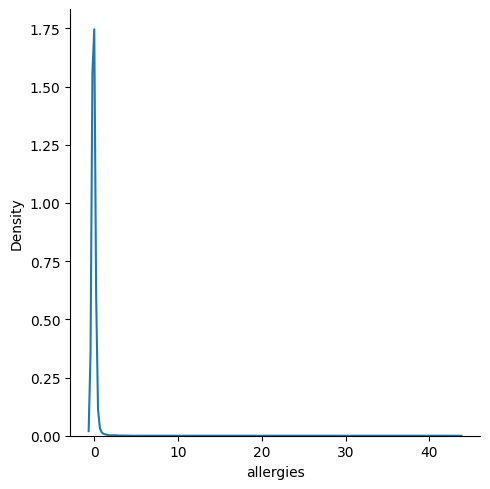

In [ ]:
sns.displot(sframe, x='allergies', kind='kde')

In [ ]:
cmatrix = sframe.cov()

In [ ]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [ ]:
cmatrix.to_csv('csv/menopause_symptom_covariance.csv', index=True)

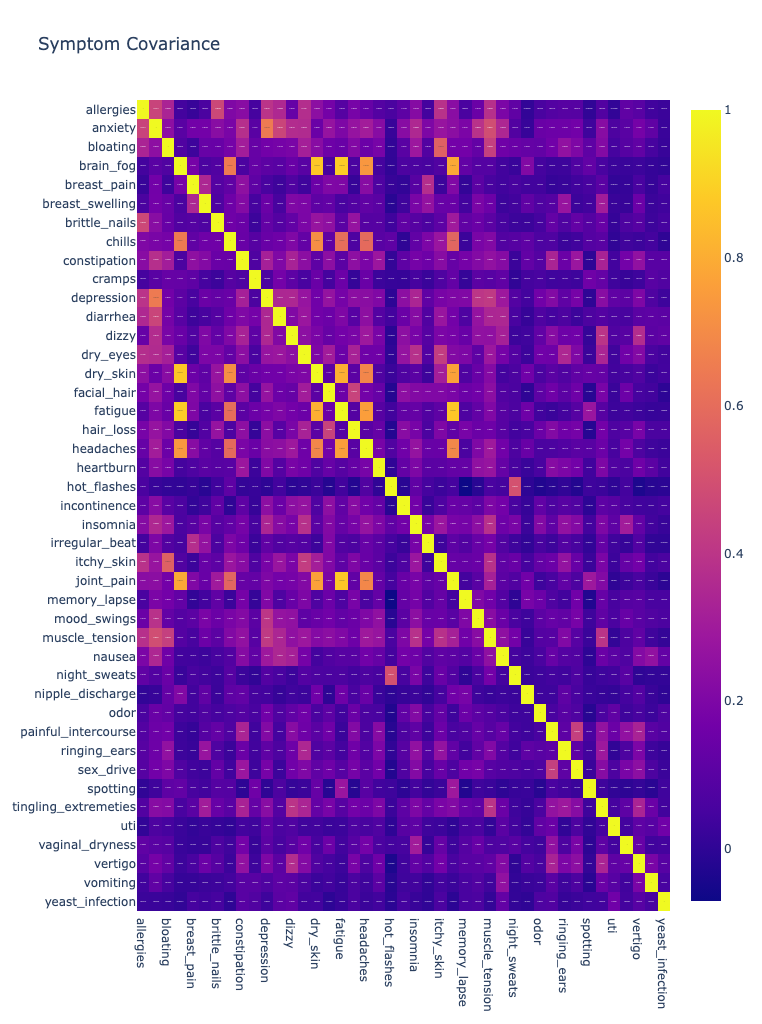

In [ ]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('figures/menopause_symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

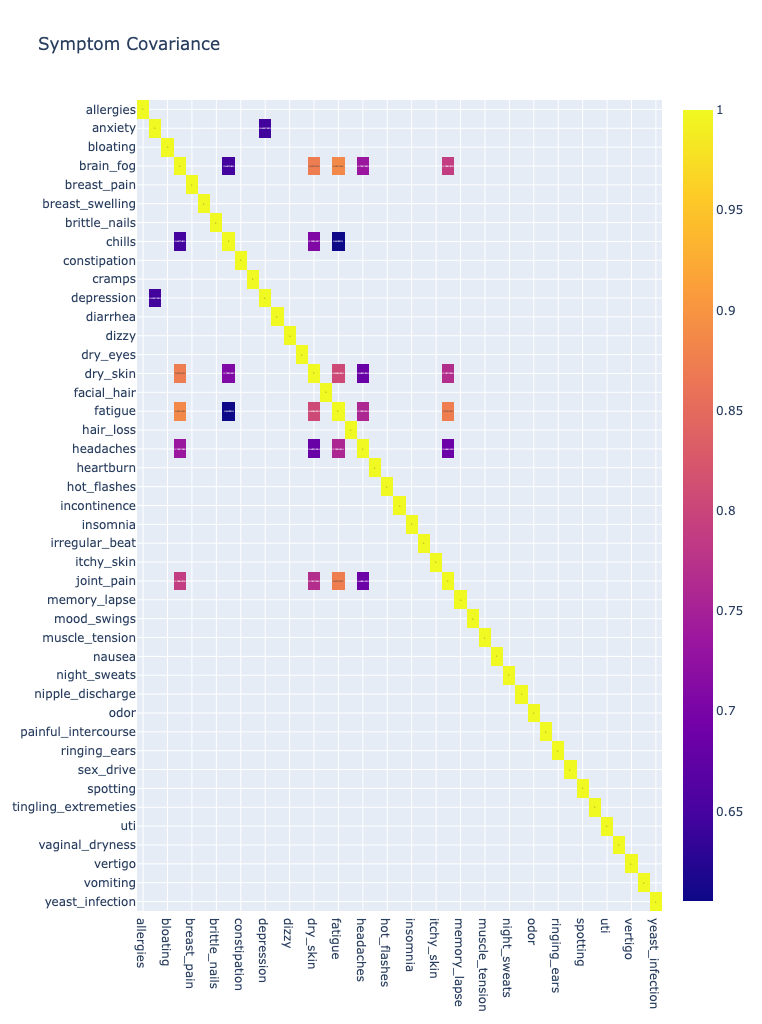

anxiety - depression - 0.6457492532535619
brain_fog - chills - 0.647581133792803
brain_fog - dry_skin - 0.8725003452740006
brain_fog - fatigue - 0.8874461587856288
brain_fog - headaches - 0.7357295082192693
brain_fog - joint_pain - 0.7882976462754699
chills - brain_fog - 0.647581133792803
chills - dry_skin - 0.7080057152599032
chills - fatigue - 0.6053009599973678
depression - anxiety - 0.6457492532535619
dry_skin - brain_fog - 0.8725003452740006
dry_skin - chills - 0.7080057152599032
dry_skin - fatigue - 0.8066342885359384
dry_skin - headaches - 0.6835353900183618
dry_skin - joint_pain - 0.7673322310950453
fatigue - brain_fog - 0.8874461587856288
fatigue - chills - 0.6053009599973678
fatigue - dry_skin - 0.8066342885359384
fatigue - headaches - 0.7590914034890782
fatigue - joint_pain - 0.8730326668830563
headaches - brain_fog - 0.7357295082192693
headaches - dry_skin - 0.6835353900183618
headaches - fatigue - 0.7590914034890782
headaches - joint_pain - 0.6860128720078469
joint_pain - 

In [ ]:
th = 0.6
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

## Cluster Map

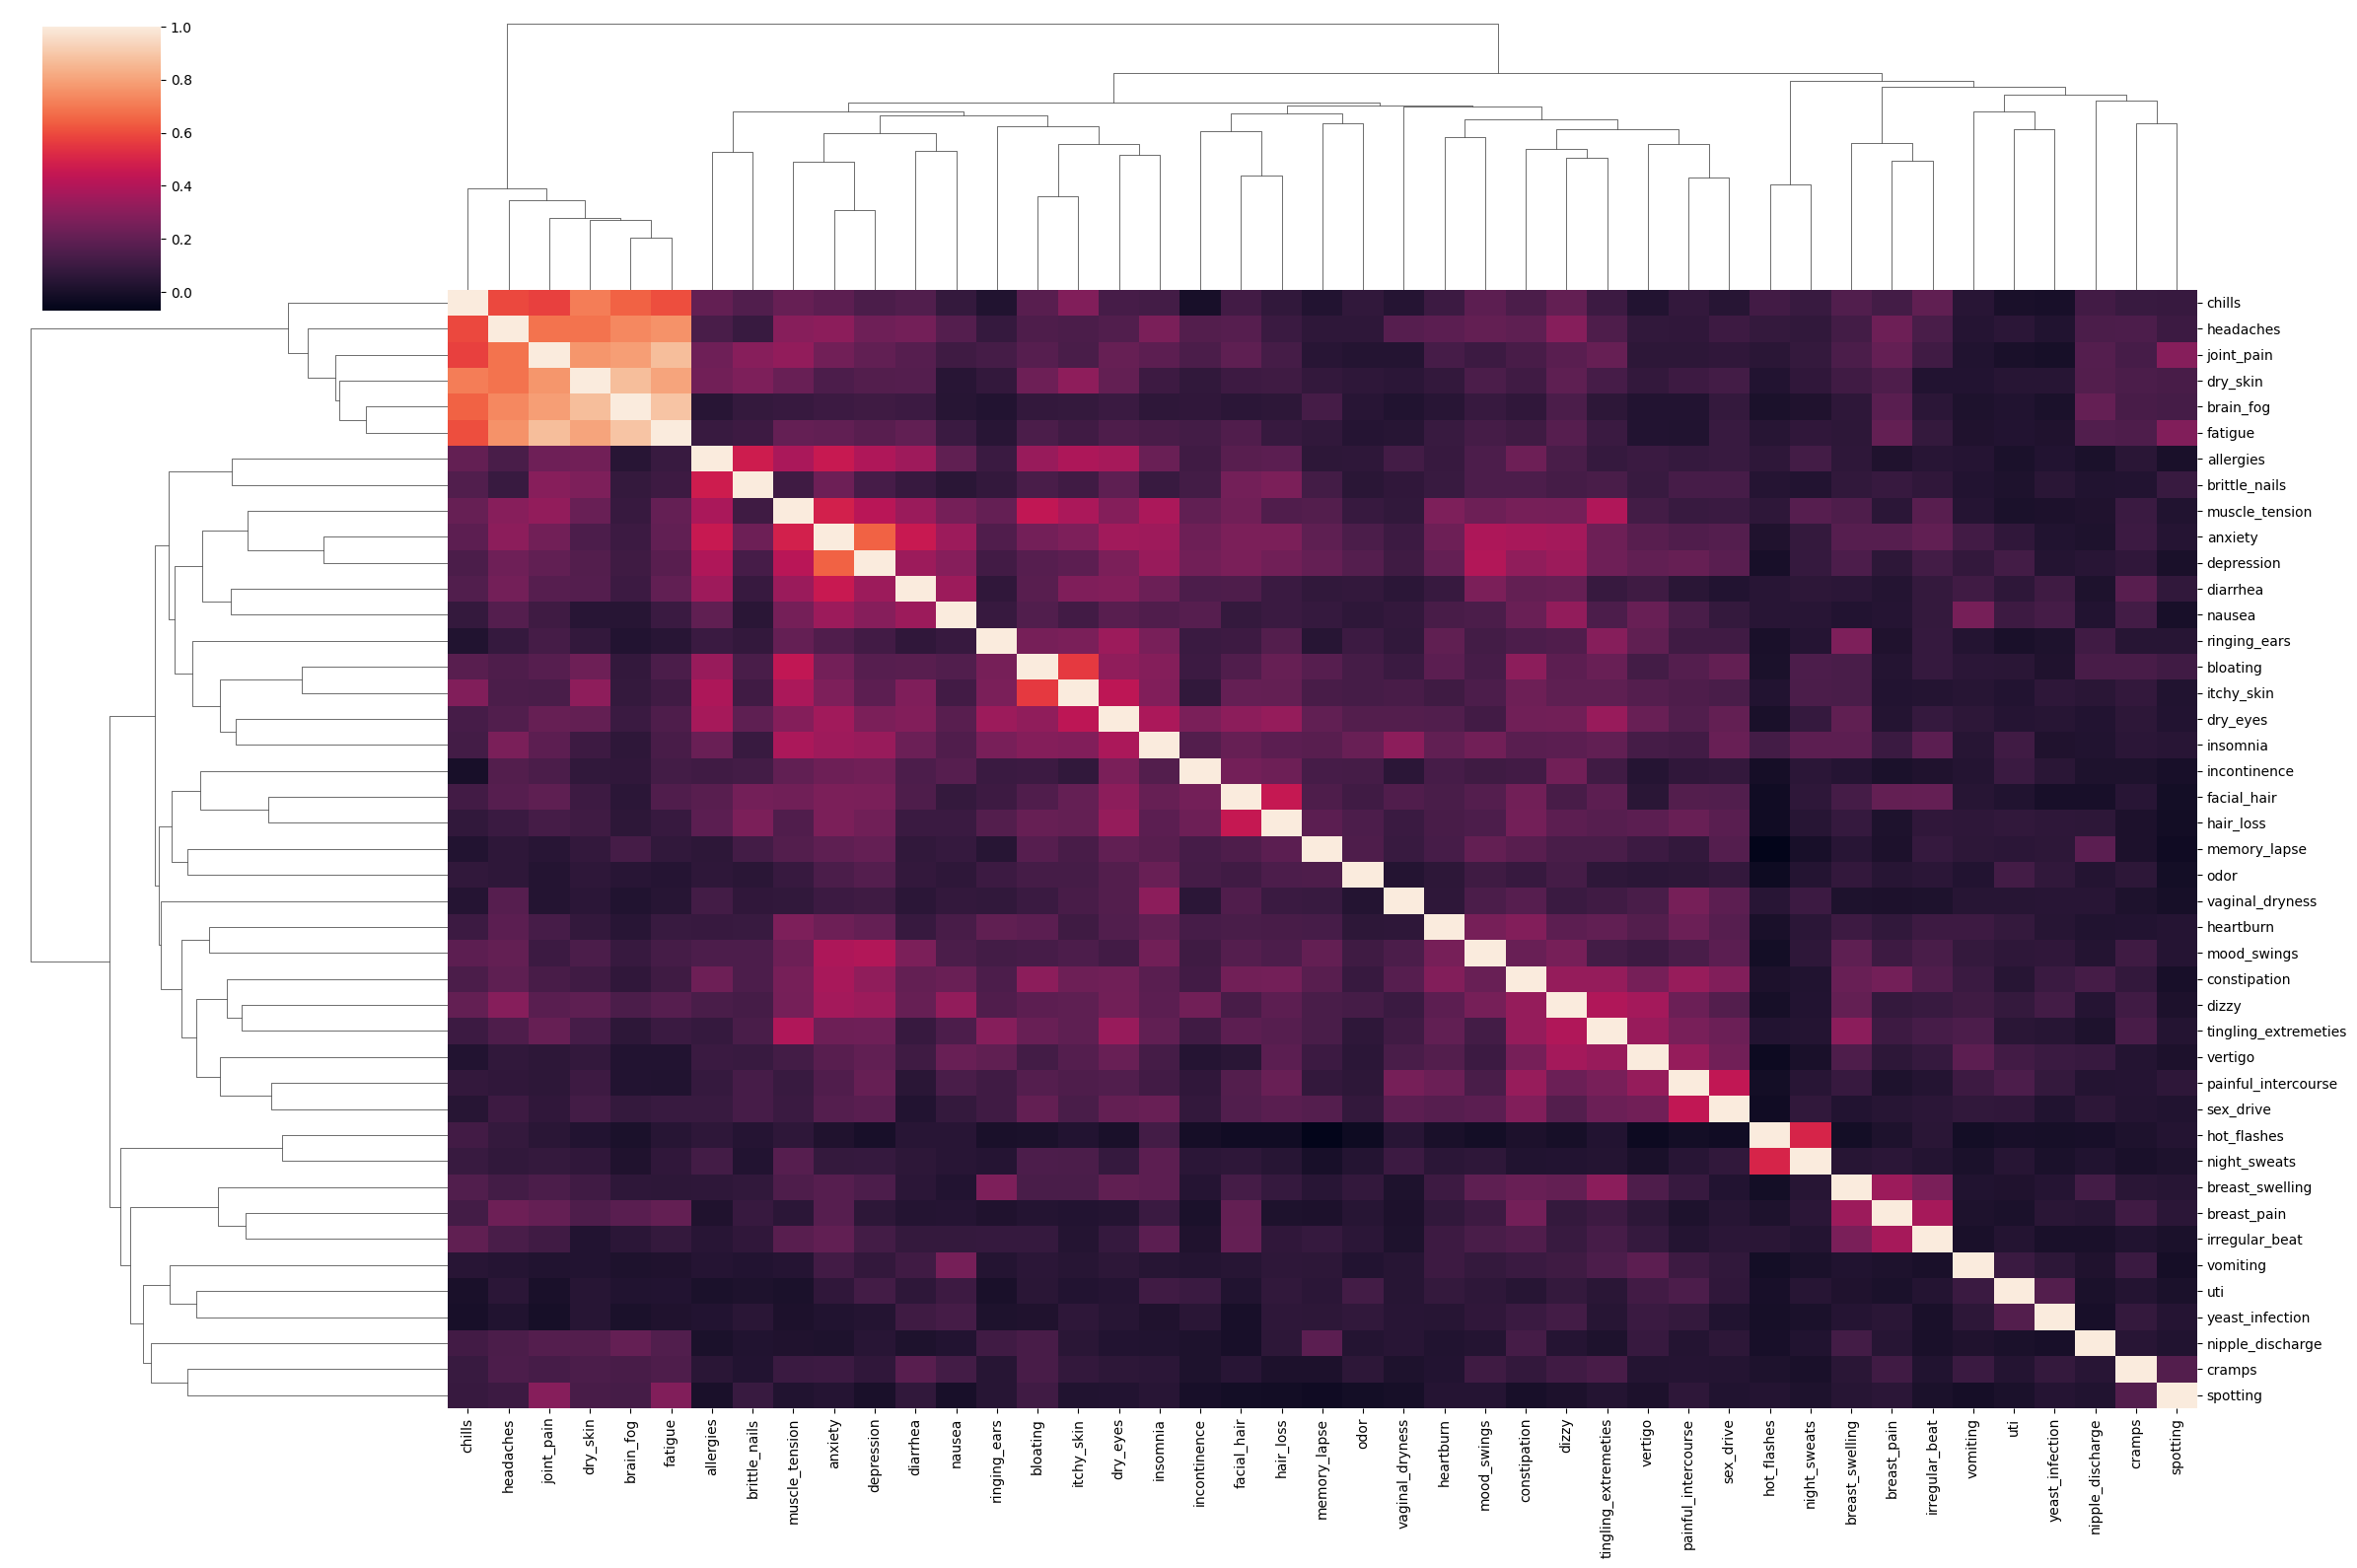

In [ ]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [ ]:
hcluster.savefig('figures/symptom_co_hirach_menopausal.png')

In [ ]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [ ]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 2


## Perform PCA analysis on the data.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [ ]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [ ]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [ ]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.74, 0.74
PCA2 - 0.12, 0.86
PCA3 - 0.04, 0.90
PCA4 - 0.03, 0.93
PCA5 - 0.01, 0.94
PCA6 - 0.01, 0.95
PCA7 - 0.01, 0.95
PCA8 - 0.01, 0.96
PCA9 - 0.00, 0.96
PCA10 - 0.00, 0.97
PCA11 - 0.00, 0.97
PCA12 - 0.00, 0.97
PCA13 - 0.00, 0.97
PCA14 - 0.00, 0.98
PCA15 - 0.00, 0.98


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (96%).

In [ ]:
pcacomponents = pca.fit_transform(X)

In [ ]:
pcacomponents.shape

(3469, 15)

In [ ]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

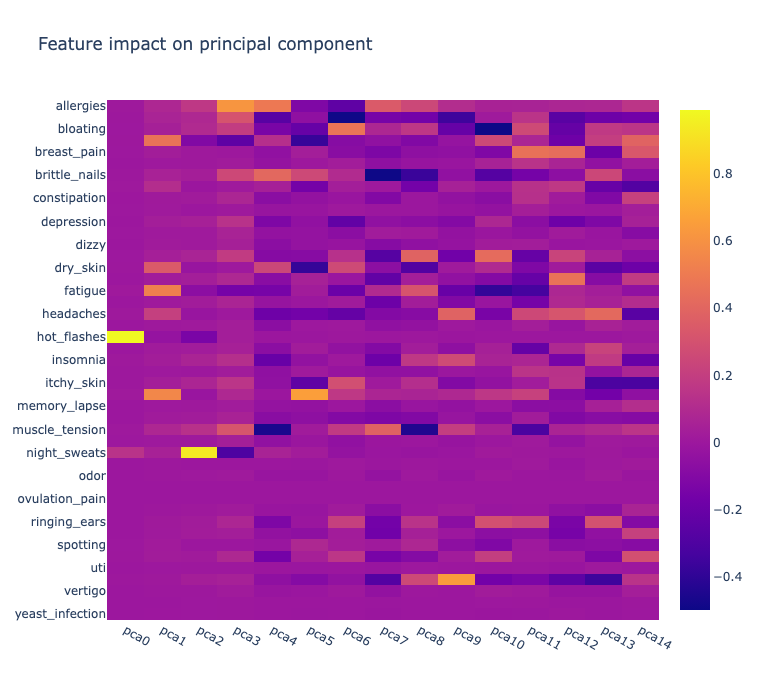

In [ ]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

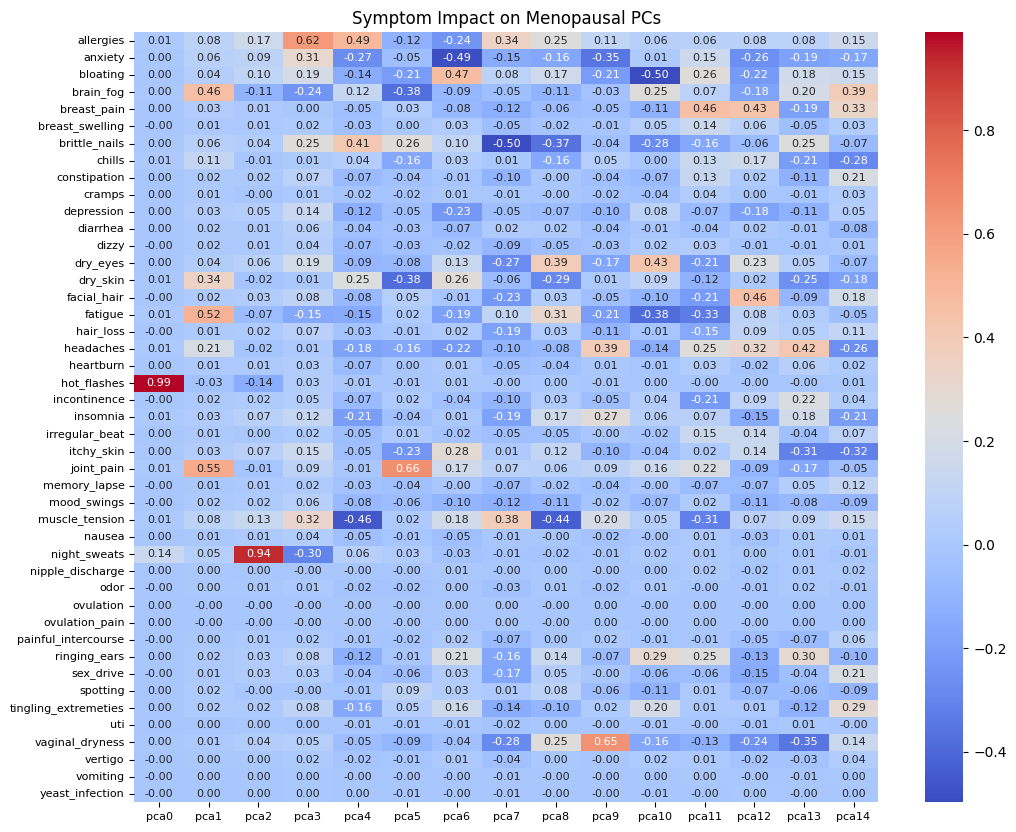

In [ ]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 80% variance

In [ ]:
pca = PCA(n_components=4, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(3469, 4)

In [ ]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

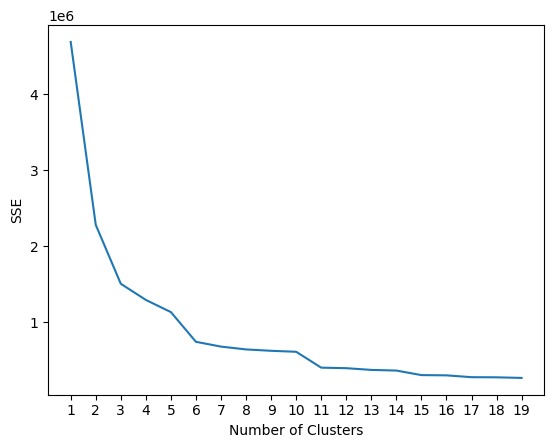

In [ ]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

6

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **6**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

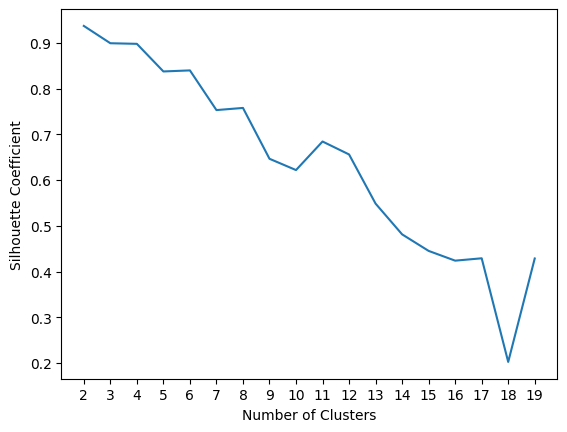

In [ ]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [ ]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 1
1 - 226
2 - 37
3 - 3102
4 - 13
5 - 71
6 - 19


## Get the users which belong to each of these clusters

In [ ]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [ ]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [ ]:
## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [ ]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['brain_fog' 'fatigue' 'joint_pain' 'dry_skin' 'headaches']
Segment 1
['hot_flashes' 'night_sweats' 'fatigue' 'joint_pain' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'headaches' 'vaginal_dryness' 'insomnia']
Segment 3
['hot_flashes' 'fatigue' 'bloating' 'anxiety' 'joint_pain']
Segment 4
['allergies' 'joint_pain' 'hot_flashes' 'muscle_tension' 'anxiety']
Segment 5
['hot_flashes' 'night_sweats' 'fatigue' 'chills' 'joint_pain']
Segment 6
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 20
1 - 3335
2 - 114
Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']
Segment 1
['hot_flashes' 'fatigue' 'joint_pain' 'bloating' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'joint_pain' 'fatigue' 'allergies']


In [1]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from sensorfabric.athena import athena

In [3]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [4]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [96]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [6]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [7]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Original Query Isn't Great - Leaves in Some of the Wrong Folks

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            )
            AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%')
            
            AND (
            answers NOT LIKE '%Chemotherapy%'
            AND answers NOT LIKE 'Unpredictable'
            AND answers NOT LIKE 'Regular cycle'
            )
            OR answers NOT LIKE 'none'
        )
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(25577, 3)


uid           name  count
0  5f8f274466dae0d0328adb80       bloating      1
1  5f8f274466dae0d0328adb80      headaches      1
2  5f8f274466dae0d0328adb80  brittle_nails      1
3  5f90eb35a42cd9d7053ec1d5   constipation      1
4  5f90eb35a42cd9d7053ec1d5    hot_flashes      1

## Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months

In [124]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(50526, 3)


uid                 name  count
0  5f92aeffa42cd9d7053ec1ff          mood_swings      2
1  5f92aeffa42cd9d7053ec1ff              fatigue      2
2  5f92aeffa42cd9d7053ec1ff           itchy_skin      2
3  5f92aeffa42cd9d7053ec1ff  painful_intercourse      2
4  5f92aeffa42cd9d7053ec1ff            sex_drive      2

## Check the onboarding data of who actually showed up in the query

In [125]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(226919, 3)


In [ ]:
menopausalusers_onboarding.to_csv('onboarding_menopausal_check.csv')

In [126]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3587


## Create Dataframe of Queried Data

In [127]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [128]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [129]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 3434


In [130]:
# Calculate the unique number of UIDs

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3587


In [ ]:
frame.to_csv('menopausalsymptomstest.csv')

In [ ]:
frame.head()

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                0        0                0     0   
5f93fc6ea42cd9d7053ec24b                0        0                0     0   
5f9605bea42cd9d7053ec2bb                0        0                0     0   
5f97799144eca8ead4eca01f                0        0                0     0   
5f982c6344eca8ead4eca0c1                0        0                0     0   

                          vomiting  
uid                                 
5f92aeffa42cd9d7053ec1ff         0  
5f93fc6ea42cd9d7053ec24b         0  
5f9605bea42cd9d7053ec2bb         0  
5f97799144eca8ead4eca01f         0  
5f982c6344eca8ead4eca0c1         0  

[5 rows x 45 columns]

In [14]:
frame.shape

(3469, 45)

In [ ]:
encoding = frame.copy(deep=True)

In [ ]:
encoding

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   
...                                       ...      ...      ...       ...   
640f7cf44c33a20028c6102e                    0        1        1         0   
640fa88a4c33a20028c610dd                    0        1        0         0   
640fd8074c33a20028c61183                    1        3        1         0   
64105b7e4c33a20028c6127f                    0        0        0         0   
64219629df7eeb0028d604cf                    0        1        1         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   
...                       ...        ...       ...         ...          ...   
640f7cf44c33a20028c6102e    0          1         1           0            1   
640fa88a4c33a20028c610dd    0          0         1           0            1   
640fd8074c33a20028c61183    0          1         2           1            2   
64105b7e4c33a20028c6127f    0          0         0           0           73   
64219629df7eeb0028d604cf    0          1         0           0            0   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   
...                               ...  ...     ...           ...   
640f7cf44c33a20028c6102e            0  ...       0             0   
640fa88a4c33a20028c610dd            1  ...       0             1   
640fd8074c33a20028c61183            2  ...       0             0   
64105b7e4c33a20028c6127f            1  ...       0             0   
64219629df7eeb0028d604cf            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   
...                                  ...               ...        ...   
640f7cf44c33a20028c6102e               1                 0          0   
640fa88a4c33a20028c610dd               0                 0          0   
640fd8074c33a20028c61183               1                 0          0   
64105b7e4c33a20028c6127f               0                 0          0   
64219629df7eeb0028d604cf               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aef

In [ ]:
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0

In [ ]:
encoding = encoding.applymap(replace_map)

In [ ]:
# Save this into a csv file so we can use it from inside R.
encoding.to_csv('csv/symptoms_menopause_onehot.csv', index=False)

In [131]:
frame=frame.astype(int)

In [132]:
data_type = frame[symptoms].dtypes

In [133]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count = frame.sum().sum()
print("Total count of all symptoms:", total_symptom_count)


Total count of all symptoms: 98197


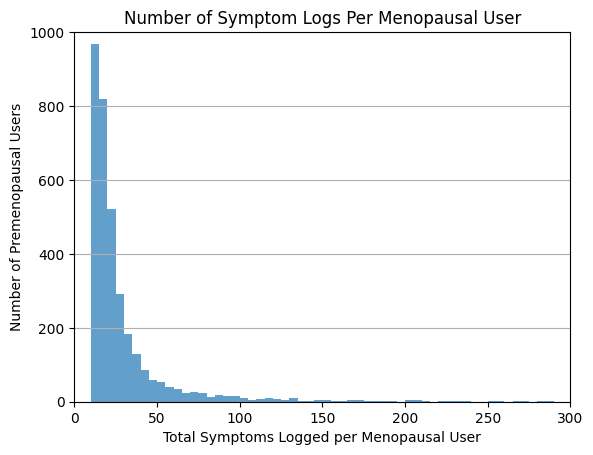

Median Symptoms per User: 19.0
Median Absolute Deviation (MAD) of Symptoms per User: 6.0


In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = frame.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7)
plt.xlabel('Total Symptoms Logged per Menopausal User')
plt.ylabel('Number of Premenopausal Users')
plt.title('Number of Symptom Logs Per Menopausal User')
plt.grid(axis='y')
plt.ylim(0,1000) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)

In [135]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 20.85%
fatigue: 5.28%
night_sweats: 4.66%
bloating: 4.04%
joint_pain: 3.97%
anxiety: 3.95%
brain_fog: 3.41%
headaches: 3.16%
allergies: 3.01%
dry_skin: 2.98%
insomnia: 2.94%
dry_eyes: 2.54%
mood_swings: 2.52%
depression: 2.48%
muscle_tension: 2.44%
brittle_nails: 2.41%
sex_drive: 2.15%
facial_hair: 2.08%
itchy_skin: 2.04%
memory_lapse: 1.97%
hair_loss: 1.79%
constipation: 1.75%
ringing_ears: 1.54%
vaginal_dryness: 1.49%
tingling_extremeties: 1.45%
incontinence: 1.38%
dizzy: 1.35%
chills: 1.33%
heartburn: 1.24%
irregular_beat: 0.98%
breast_pain: 0.94%
nausea: 0.91%
odor: 0.86%
diarrhea: 0.79%
cramps: 0.68%
painful_intercourse: 0.65%
vertigo: 0.51%
breast_swelling: 0.47%
uti: 0.34%
spotting: 0.26%
yeast_infection: 0.22%
vomiting: 0.09%
nipple_discharge: 0.08%
ovulation: 0.00%
ovulation_pain: 0.00%


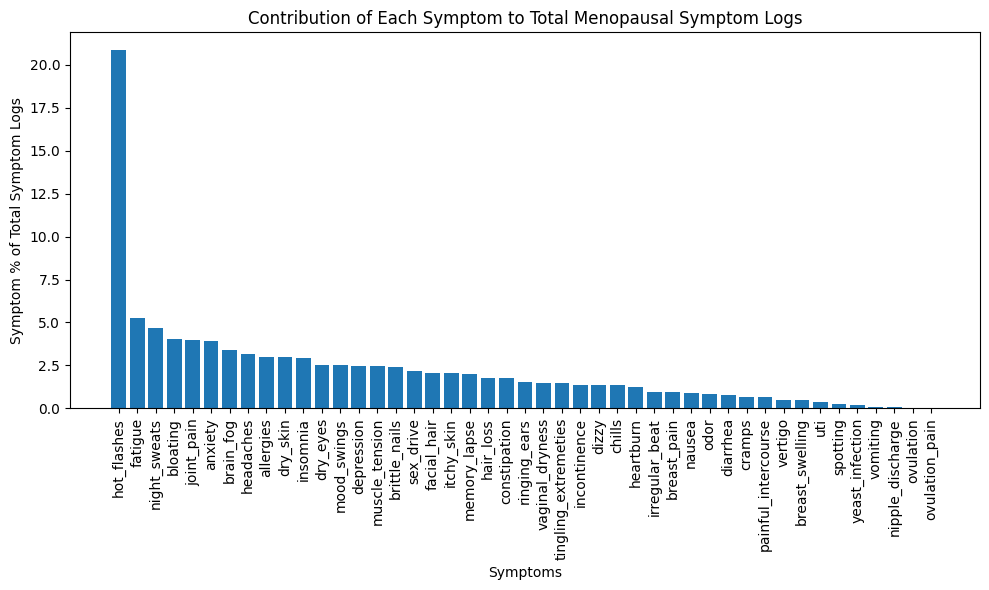

In [136]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Menopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [137]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 75.247525
hot_flashes             73.675015
anxiety                 57.542225
joint_pain              57.396622
bloating                56.697729
brain_fog               56.377402
night_sweats            54.135119
insomnia                52.125801
headaches               48.806057
dry_skin                48.078043
mood_swings             46.709377
depression              44.350612
memory_lapse            42.894584
sex_drive               42.137449
brittle_nails           40.477577
muscle_tension          40.186372
allergies               39.662202
itchy_skin              38.555620
facial_hair             37.274316
dry_eyes                36.488061
hair_loss               34.915550
constipation            33.343040
vaginal_dryness         28.741992
tingling_extremeties    28.538148
dizzy                   26.354106
ringing_ears            23.995341
incontinence            23.937100
heartburn               23.616773
chills                  20.384391
irregular_beat

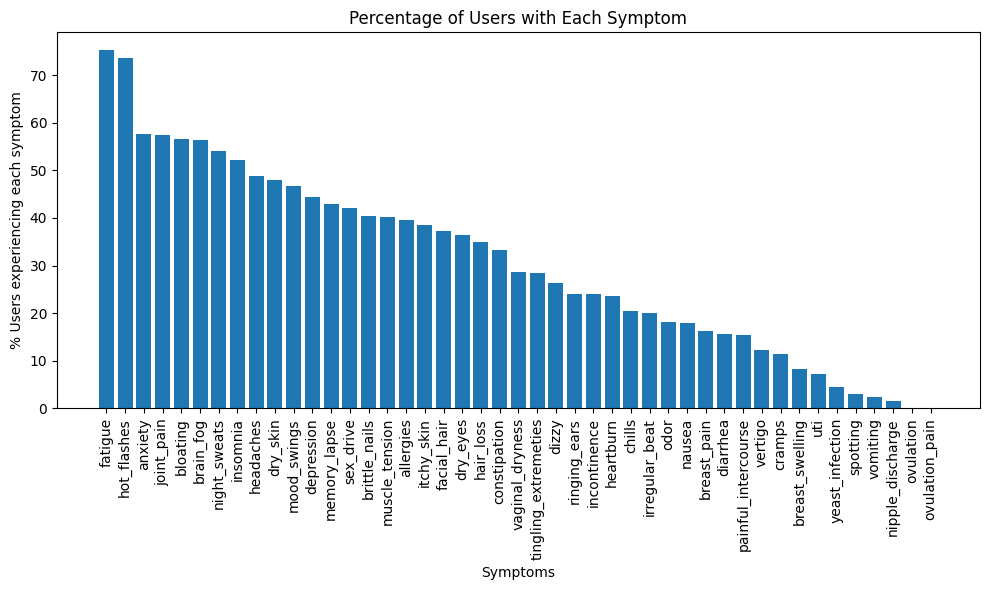

In [138]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [139]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


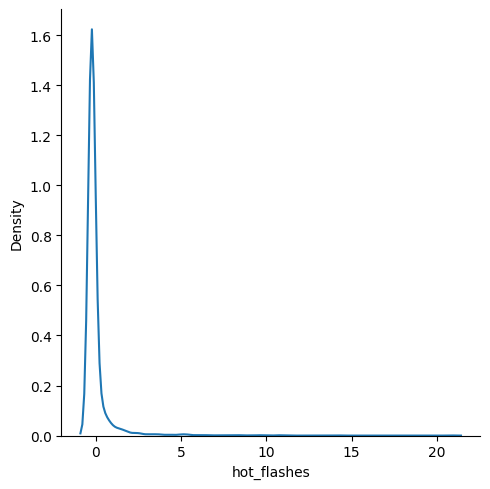

In [46]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


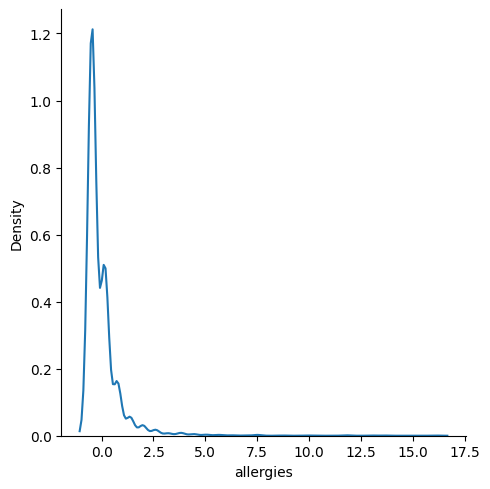

In [47]:
sns.displot(sframe, x='allergies', kind='kde')

In [140]:
cmatrix = sframe.cov()

In [141]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [ ]:
cmatrix.to_csv('csv/menopause_symptom_covariance.csv', index=True)

In [142]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('menopause_symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

In [143]:
th = 0.6
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

## Cluster Map

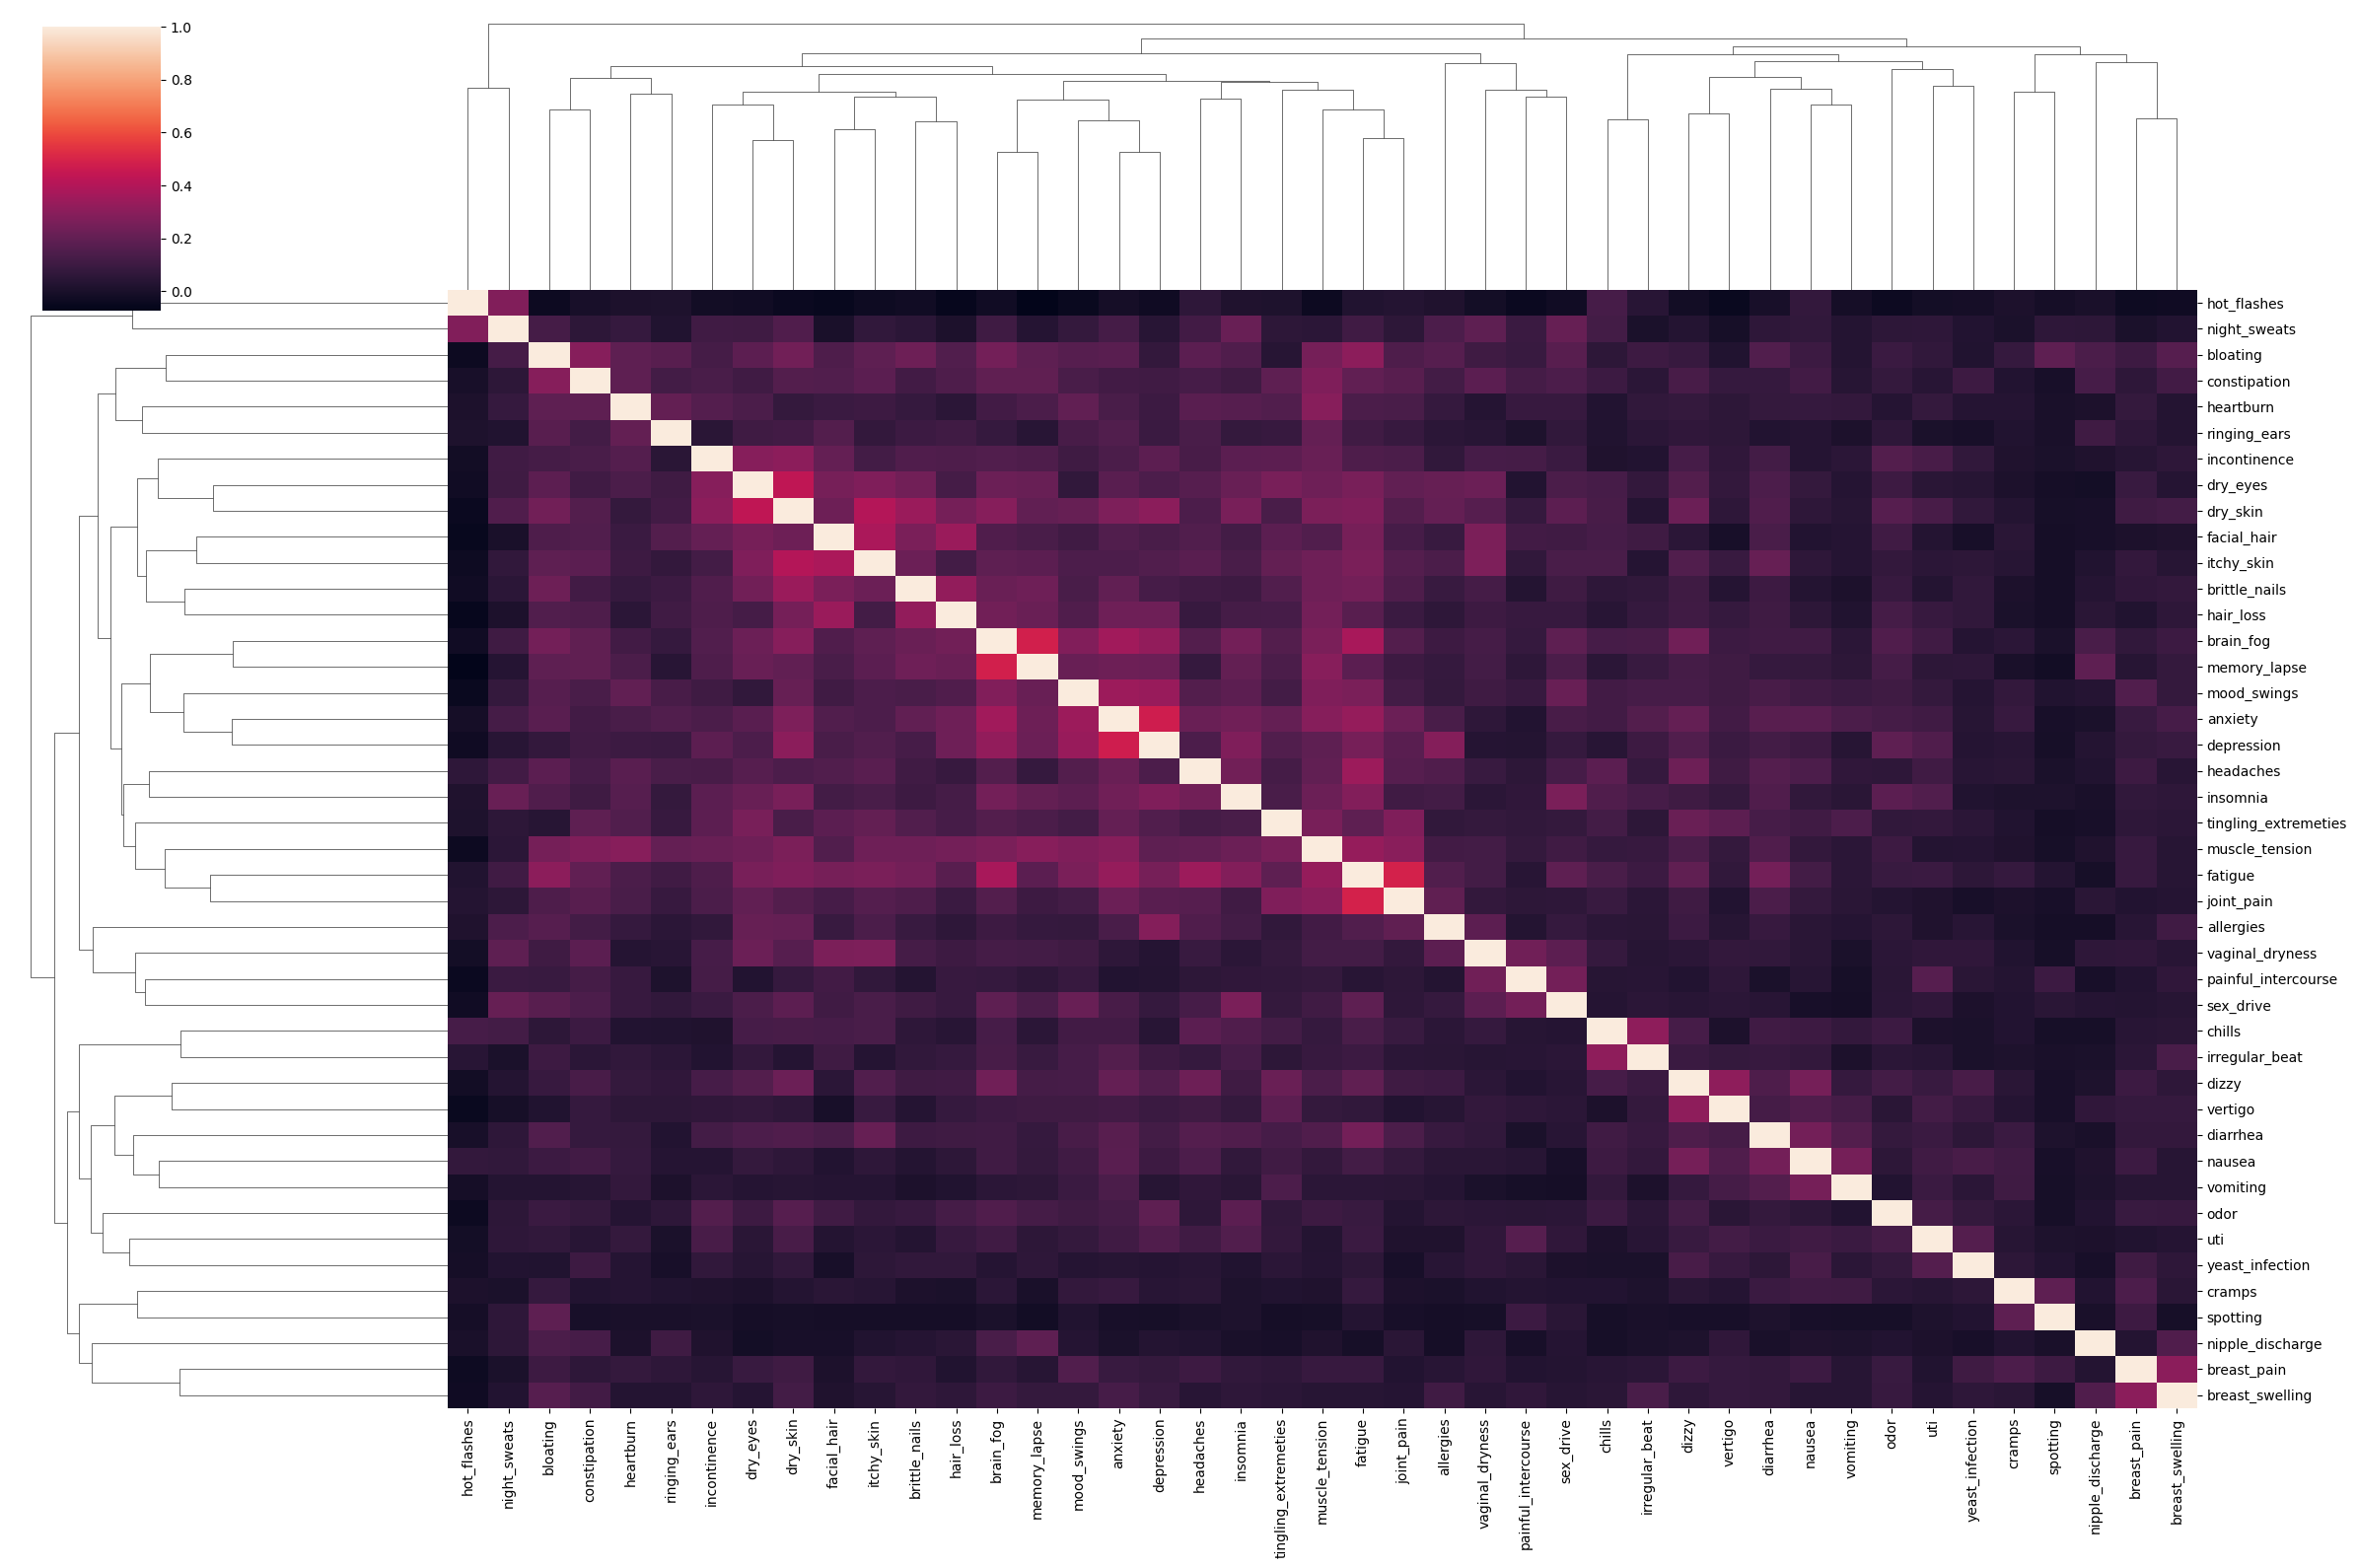

In [144]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [ ]:
hcluster.savefig('figures/symptom_co_hirach_menopausal.png')

In [145]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [103]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 2


## Perform PCA analysis on the data.

In [104]:
from sklearn.decomposition import PCA

In [105]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [106]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [107]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [108]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.83, 0.83
PCA2 - 0.04, 0.87
PCA3 - 0.02, 0.88
PCA4 - 0.01, 0.89
PCA5 - 0.01, 0.90
PCA6 - 0.01, 0.91
PCA7 - 0.01, 0.91
PCA8 - 0.01, 0.92
PCA9 - 0.01, 0.93
PCA10 - 0.00, 0.93
PCA11 - 0.00, 0.94
PCA12 - 0.00, 0.94
PCA13 - 0.00, 0.94
PCA14 - 0.00, 0.95
PCA15 - 0.00, 0.95


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (96%).

In [109]:
pcacomponents = pca.fit_transform(X)

In [110]:
pcacomponents.shape

(3333, 15)

In [111]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [63]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

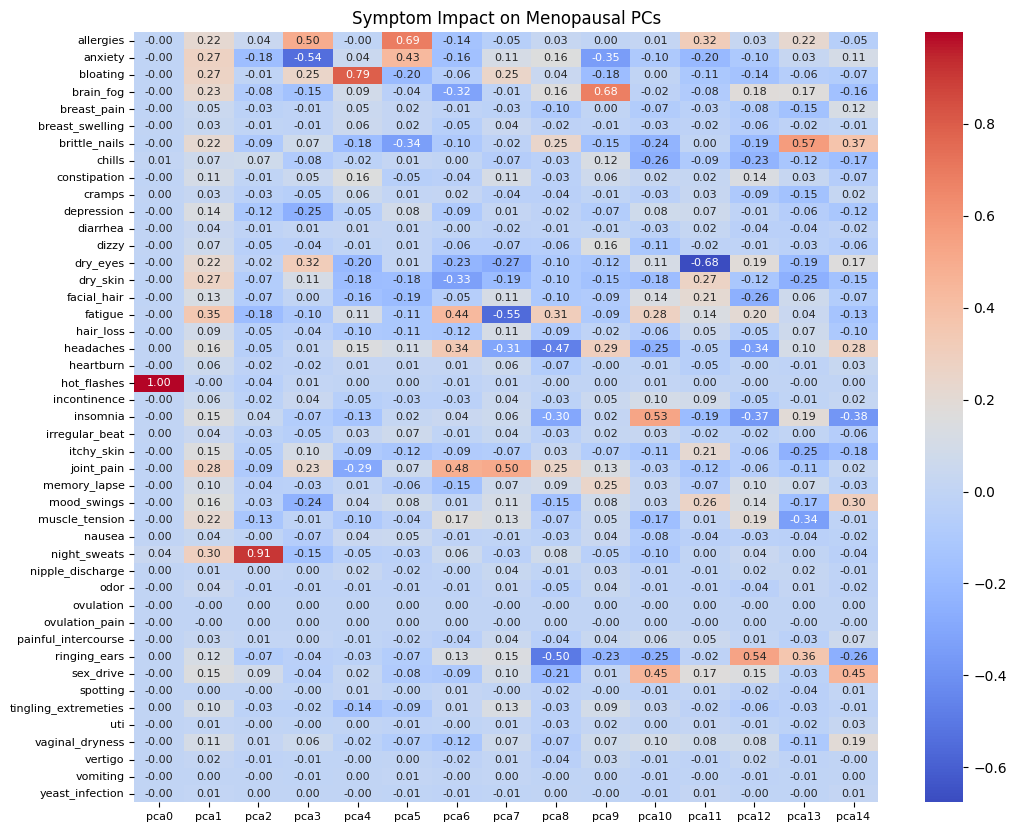

In [112]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 80% variance

In [147]:
pca = PCA(n_components=5, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(3333, 5)

In [148]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [149]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

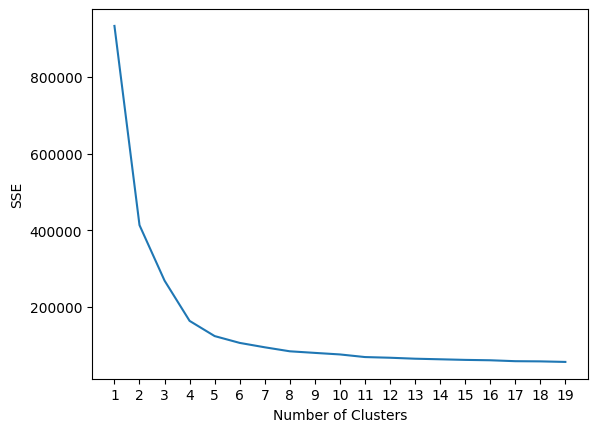

In [150]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [151]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **6**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [152]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

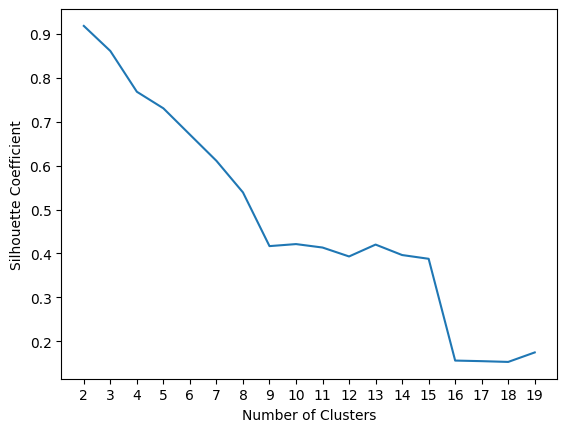

In [153]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [154]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 225
1 - 3
2 - 46
3 - 3043
4 - 16


## Get the users which belong to each of these clusters

In [155]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [156]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [157]:
## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [158]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [159]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'bloating' 'joint_pain']
Segment 1
['hot_flashes' 'night_sweats' 'chills' 'fatigue' 'depression']
Segment 2
['hot_flashes' 'night_sweats' 'headaches' 'chills' 'tingling_extremeties']
Segment 3
['hot_flashes' 'fatigue' 'bloating' 'anxiety' 'joint_pain']
Segment 4
['hot_flashes' 'night_sweats' 'nausea' 'chills' 'ringing_ears']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

## Alternatively if we use n=3 for segmentation

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 20
1 - 3335
2 - 114
Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']
Segment 1
['hot_flashes' 'fatigue' 'joint_pain' 'bloating' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'joint_pain' 'fatigue' 'allergies']


In [ ]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
from sensorfabric.athena import athena

In [ ]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [ ]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [ ]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [ ]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [ ]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Original Query Isn't Great - Leaves in Some of the Wrong Folks

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            )
            AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%')
            
            AND (
            answers NOT LIKE '%Chemotherapy%'
            AND answers NOT LIKE 'Unpredictable'
            AND answers NOT LIKE 'Regular cycle'
            )
            OR answers NOT LIKE 'none'
        )
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(25577, 3)


uid           name  count
0  5f8f274466dae0d0328adb80       bloating      1
1  5f8f274466dae0d0328adb80      headaches      1
2  5f8f274466dae0d0328adb80  brittle_nails      1
3  5f90eb35a42cd9d7053ec1d5   constipation      1
4  5f90eb35a42cd9d7053ec1d5    hot_flashes      1

## Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months

In [ ]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(51271, 3)


uid                 name  count
0  5f92aeffa42cd9d7053ec1ff  painful_intercourse      2
1  5f92aeffa42cd9d7053ec1ff              anxiety      2
2  5f92aeffa42cd9d7053ec1ff              fatigue      2
3  5f92aeffa42cd9d7053ec1ff             spotting      2
4  5f92aeffa42cd9d7053ec1ff                  uti      2

## Check the onboarding data of who actually showed up in the query

In [ ]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >2
        and symptoms_recorded <500
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(313517, 3)


In [ ]:
menopausalusers_onboarding.to_csv('onboarding_menopausal_check.csv')

In [ ]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3628


## Create Dataframe of Queried Data

In [ ]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [ ]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [ ]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 3469


In [ ]:
# Calculate the unique number of UIDs

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3628


In [ ]:
frame.to_csv('menopausalsymptomstest.csv')

In [ ]:
frame.head()

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                0        0                0     0   
5f93fc6ea42cd9d7053ec24b                0        0                0     0   
5f9605bea42cd9d7053ec2bb                0        0                0     0   
5f97799144eca8ead4eca01f                0        0                0     0   
5f982c6344eca8ead4eca0c1                0        0                0     0   

                          vomiting  
uid                                 
5f92aeffa42cd9d7053ec1ff         0  
5f93fc6ea42cd9d7053ec24b         0  
5f9605bea42cd9d7053ec2bb         0  
5f97799144eca8ead4eca01f         0  
5f982c6344eca8ead4eca0c1         0  

[5 rows x 45 columns]

In [ ]:
frame.shape

(3469, 45)

In [ ]:
encoding = frame.copy(deep=True)

In [ ]:
encoding

painful_intercourse  anxiety  fatigue  spotting  \
uid                                                                         
5f92aeffa42cd9d7053ec1ff                    2        2        2         2   
5f93fc6ea42cd9d7053ec24b                    0        1        2         1   
5f9605bea42cd9d7053ec2bb                    0        1        0         0   
5f97799144eca8ead4eca01f                    0        0        0         0   
5f982c6344eca8ead4eca0c1                    0        0        0         0   
...                                       ...      ...      ...       ...   
640f7cf44c33a20028c6102e                    0        1        1         0   
640fa88a4c33a20028c610dd                    0        1        0         0   
640fd8074c33a20028c61183                    1        3        1         0   
64105b7e4c33a20028c6127f                    0        0        0         0   
64219629df7eeb0028d604cf                    0        1        1         0   

                          uti  sex_drive  insomnia  joint_pain  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff    2          2         2           2            2   
5f93fc6ea42cd9d7053ec24b    0          2         0           1            3   
5f9605bea42cd9d7053ec2bb    0          0         1           1            2   
5f97799144eca8ead4eca01f    0          0         0           0           13   
5f982c6344eca8ead4eca0c1    0          0         0           0           29   
...                       ...        ...       ...         ...          ...   
640f7cf44c33a20028c6102e    0          1         1           0            1   
640fa88a4c33a20028c610dd    0          0         1           0            1   
640fd8074c33a20028c61183    0          1         2           1            2   
64105b7e4c33a20028c6127f    0          0         0           0           73   
64219629df7eeb0028d604cf    0          1         0           0            0   

                          mood_swings  ...  cramps  ringing_ears  \
uid                                    ...                         
5f92aeffa42cd9d7053ec1ff            2  ...       0             0   
5f93fc6ea42cd9d7053ec24b            3  ...       0             0   
5f9605bea42cd9d7053ec2bb            1  ...       0             0   
5f97799144eca8ead4eca01f            0  ...       0             0   
5f982c6344eca8ead4eca0c1            1  ...       0             0   
...                               ...  ...     ...           ...   
640f7cf44c33a20028c6102e            0  ...       0             0   
640fa88a4c33a20028c610dd            1  ...       0             1   
640fd8074c33a20028c61183            2  ...       0             0   
64105b7e4c33a20028c6127f            1  ...       0             0   
64219629df7eeb0028d604cf            1  ...       0             0   

                          irregular_beat  nipple_discharge  ovulation  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff               0                 0          0   
5f93fc6ea42cd9d7053ec24b               0                 0          0   
5f9605bea42cd9d7053ec2bb               0                 0          0   
5f97799144eca8ead4eca01f               0                 0          0   
5f982c6344eca8ead4eca0c1               0                 0          0   
...                                  ...               ...        ...   
640f7cf44c33a20028c6102e               1                 0          0   
640fa88a4c33a20028c610dd               0                 0          0   
640fd8074c33a20028c61183               1                 0          0   
64105b7e4c33a20028c6127f               0                 0          0   
64219629df7eeb0028d604cf               0                 0          0   

                          yeast_infection  vertigo  breast_swelling  odor  \
uid                                                                         
5f92aef

In [ ]:
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0

In [ ]:
encoding = encoding.applymap(replace_map)

In [ ]:
# Save this into a csv file so we can use it from inside R.
encoding.to_csv('csv/symptoms_menopause_onehot.csv', index=False)

In [ ]:
frame=frame.astype(int)

In [ ]:
data_type = frame[symptoms].dtypes

In [ ]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count = frame.sum().sum()
print("Total count of all symptoms:", total_symptom_count)


Total count of all symptoms: 115477


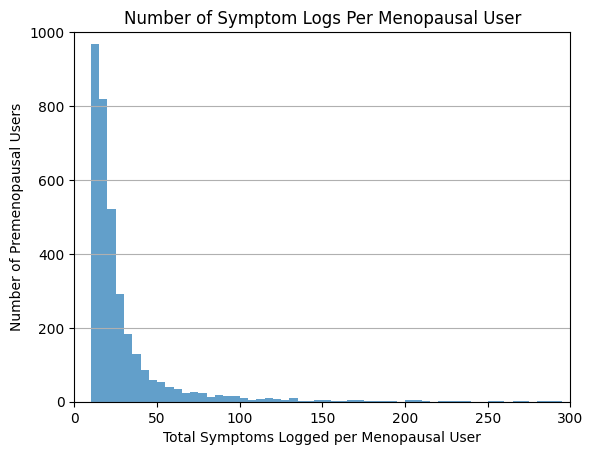

Median Symptoms per User: 19.0
Median Absolute Deviation (MAD) of Symptoms per User: 6.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = frame.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7)
plt.xlabel('Total Symptoms Logged per Menopausal User')
plt.ylabel('Number of Premenopausal Users')
plt.title('Number of Symptom Logs Per Menopausal User')
plt.grid(axis='y')
plt.ylim(0,1000) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)

In [ ]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 23.56%
fatigue: 5.21%
night_sweats: 5.18%
joint_pain: 4.39%
anxiety: 3.74%
bloating: 3.68%
brain_fog: 3.35%
headaches: 3.10%
allergies: 3.06%
dry_skin: 3.05%
insomnia: 2.77%
muscle_tension: 2.58%
dry_eyes: 2.39%
brittle_nails: 2.35%
depression: 2.27%
mood_swings: 2.24%
itchy_skin: 1.95%
facial_hair: 1.91%
sex_drive: 1.89%
memory_lapse: 1.70%
hair_loss: 1.62%
constipation: 1.60%
ringing_ears: 1.42%
tingling_extremeties: 1.41%
vaginal_dryness: 1.40%
chills: 1.35%
incontinence: 1.26%
dizzy: 1.25%
heartburn: 1.11%
breast_pain: 0.91%
irregular_beat: 0.89%
nausea: 0.82%
diarrhea: 0.76%
odor: 0.75%
cramps: 0.62%
painful_intercourse: 0.59%
breast_swelling: 0.46%
vertigo: 0.46%
uti: 0.29%
spotting: 0.29%
yeast_infection: 0.19%
vomiting: 0.08%
nipple_discharge: 0.07%
ovulation_pain: 0.00%
ovulation: 0.00%


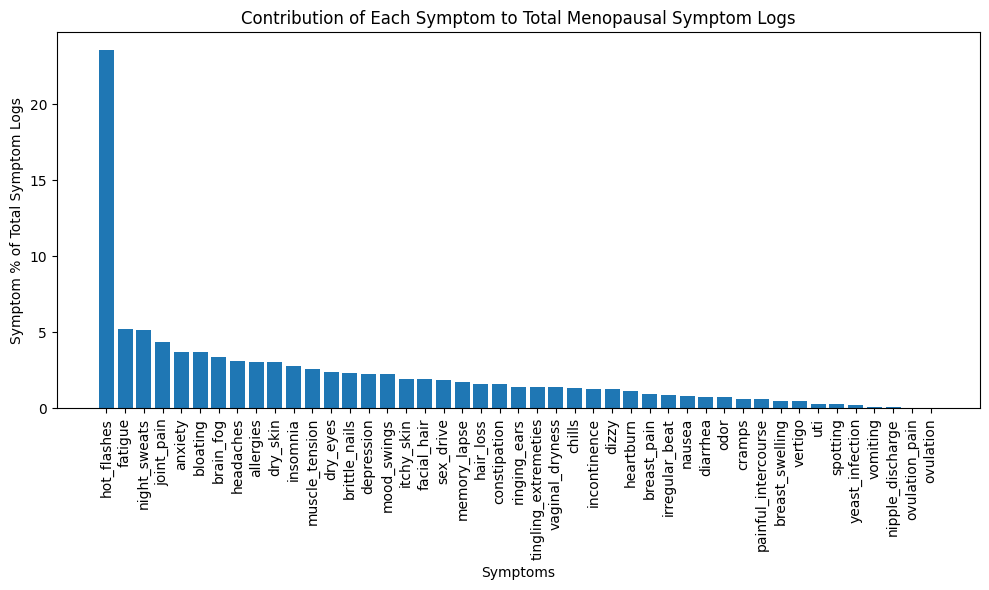

In [ ]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Menopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [ ]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 75.151340
hot_flashes             73.882963
joint_pain              57.480542
anxiety                 57.422888
bloating                56.615739
brain_fog               56.269818
night_sweats            54.338426
insomnia                52.205246
headaches               49.034304
dry_skin                48.169501
mood_swings             46.785817
depression              44.393197
memory_lapse            42.750072
sex_drive               42.029403
brittle_nails           40.530412
muscle_tension          40.299798
allergies               39.694436
itchy_skin              38.541366
facial_hair             37.186509
dry_eyes                36.523494
hair_loss               34.793889
constipation            33.381378
vaginal_dryness         28.769098
tingling_extremeties    28.653791
dizzy                   26.520611
ringing_ears            23.955030
incontinence            23.897377
heartburn               23.724416
chills                  20.611127
irregular_beat

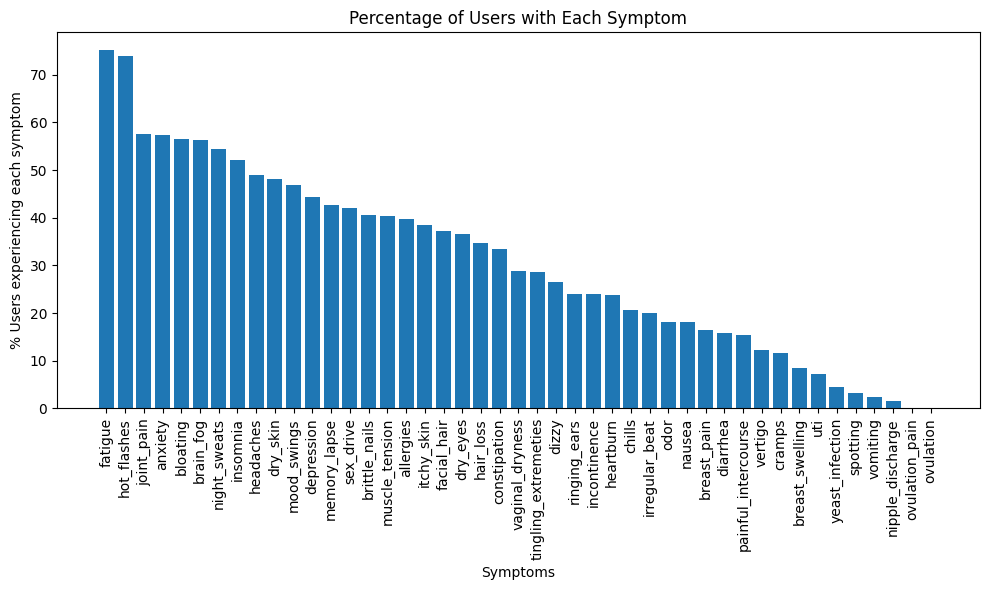

In [ ]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.title("Percentage of Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [ ]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


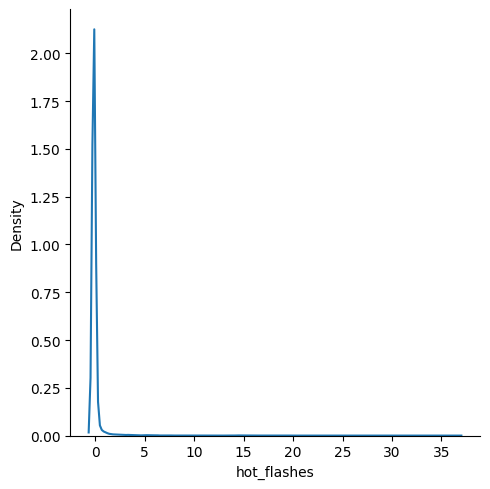

In [ ]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


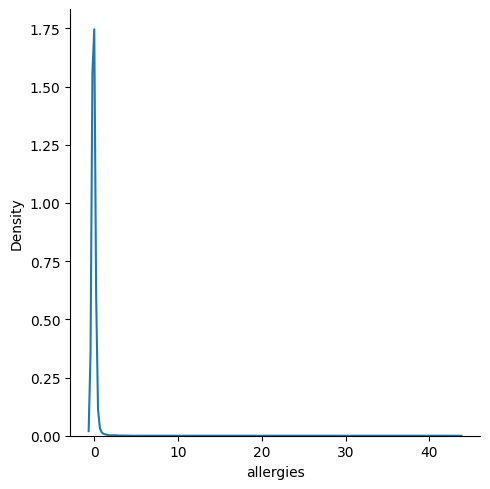

In [ ]:
sns.displot(sframe, x='allergies', kind='kde')

In [ ]:
cmatrix = sframe.cov()

In [ ]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [ ]:
cmatrix.to_csv('csv/menopause_symptom_covariance.csv', index=True)

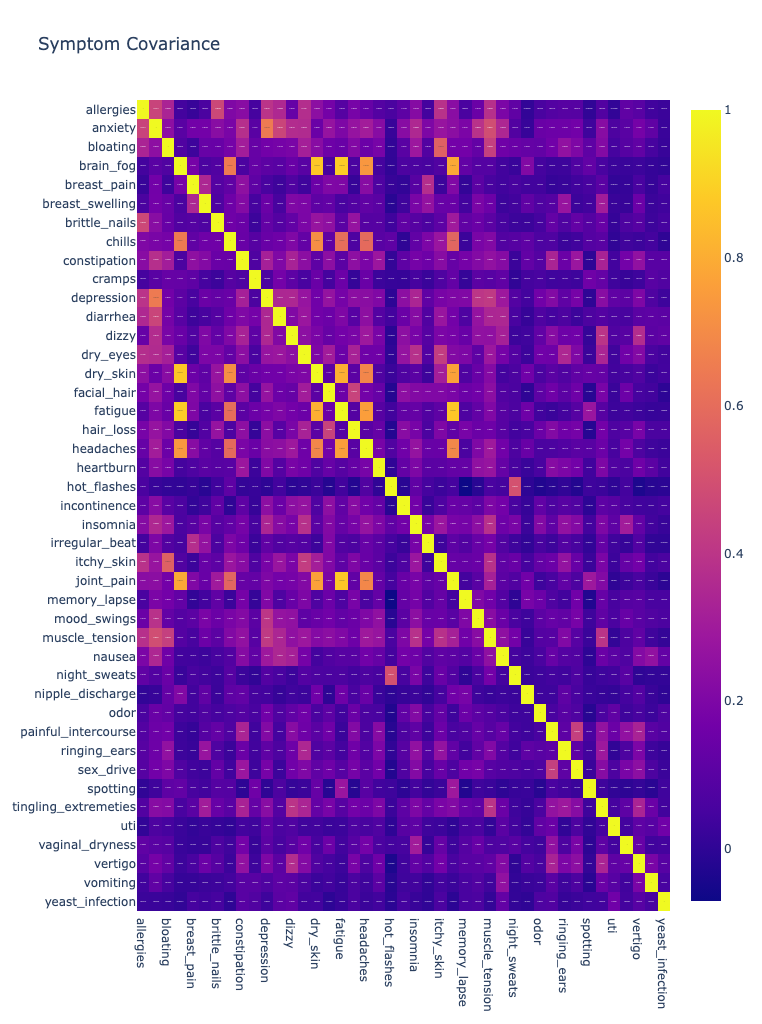

In [ ]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('figures/menopause_symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

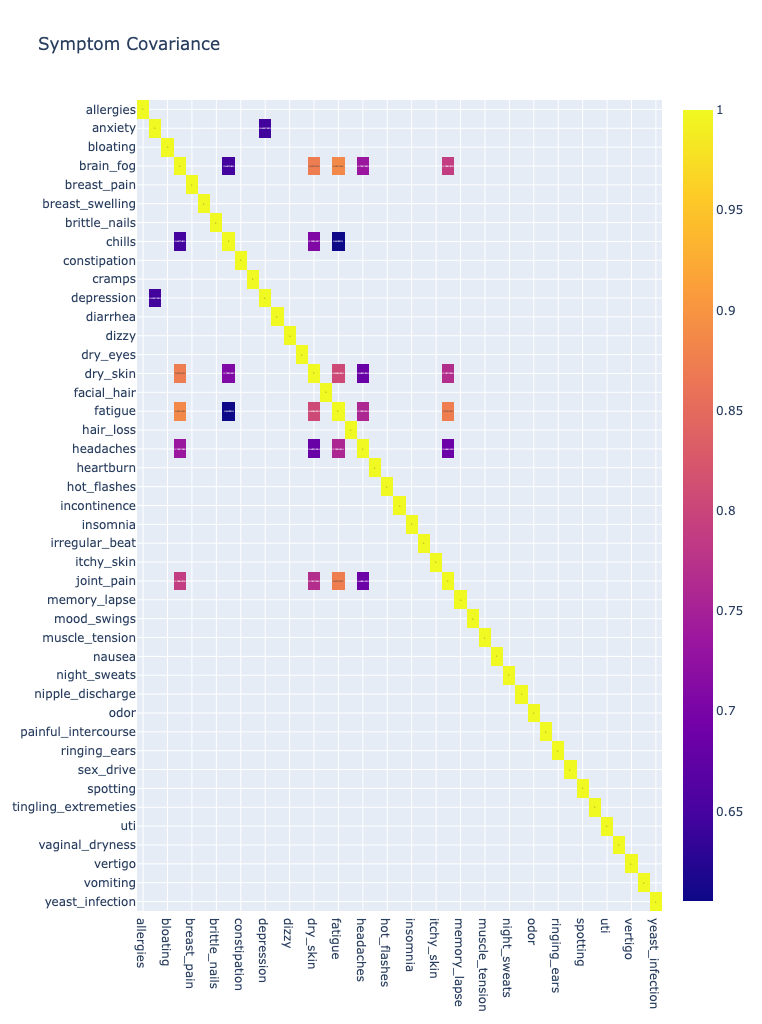

anxiety - depression - 0.6457492532535619
brain_fog - chills - 0.647581133792803
brain_fog - dry_skin - 0.8725003452740006
brain_fog - fatigue - 0.8874461587856288
brain_fog - headaches - 0.7357295082192693
brain_fog - joint_pain - 0.7882976462754699
chills - brain_fog - 0.647581133792803
chills - dry_skin - 0.7080057152599032
chills - fatigue - 0.6053009599973678
depression - anxiety - 0.6457492532535619
dry_skin - brain_fog - 0.8725003452740006
dry_skin - chills - 0.7080057152599032
dry_skin - fatigue - 0.8066342885359384
dry_skin - headaches - 0.6835353900183618
dry_skin - joint_pain - 0.7673322310950453
fatigue - brain_fog - 0.8874461587856288
fatigue - chills - 0.6053009599973678
fatigue - dry_skin - 0.8066342885359384
fatigue - headaches - 0.7590914034890782
fatigue - joint_pain - 0.8730326668830563
headaches - brain_fog - 0.7357295082192693
headaches - dry_skin - 0.6835353900183618
headaches - fatigue - 0.7590914034890782
headaches - joint_pain - 0.6860128720078469
joint_pain - 

In [ ]:
th = 0.6
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

## Cluster Map

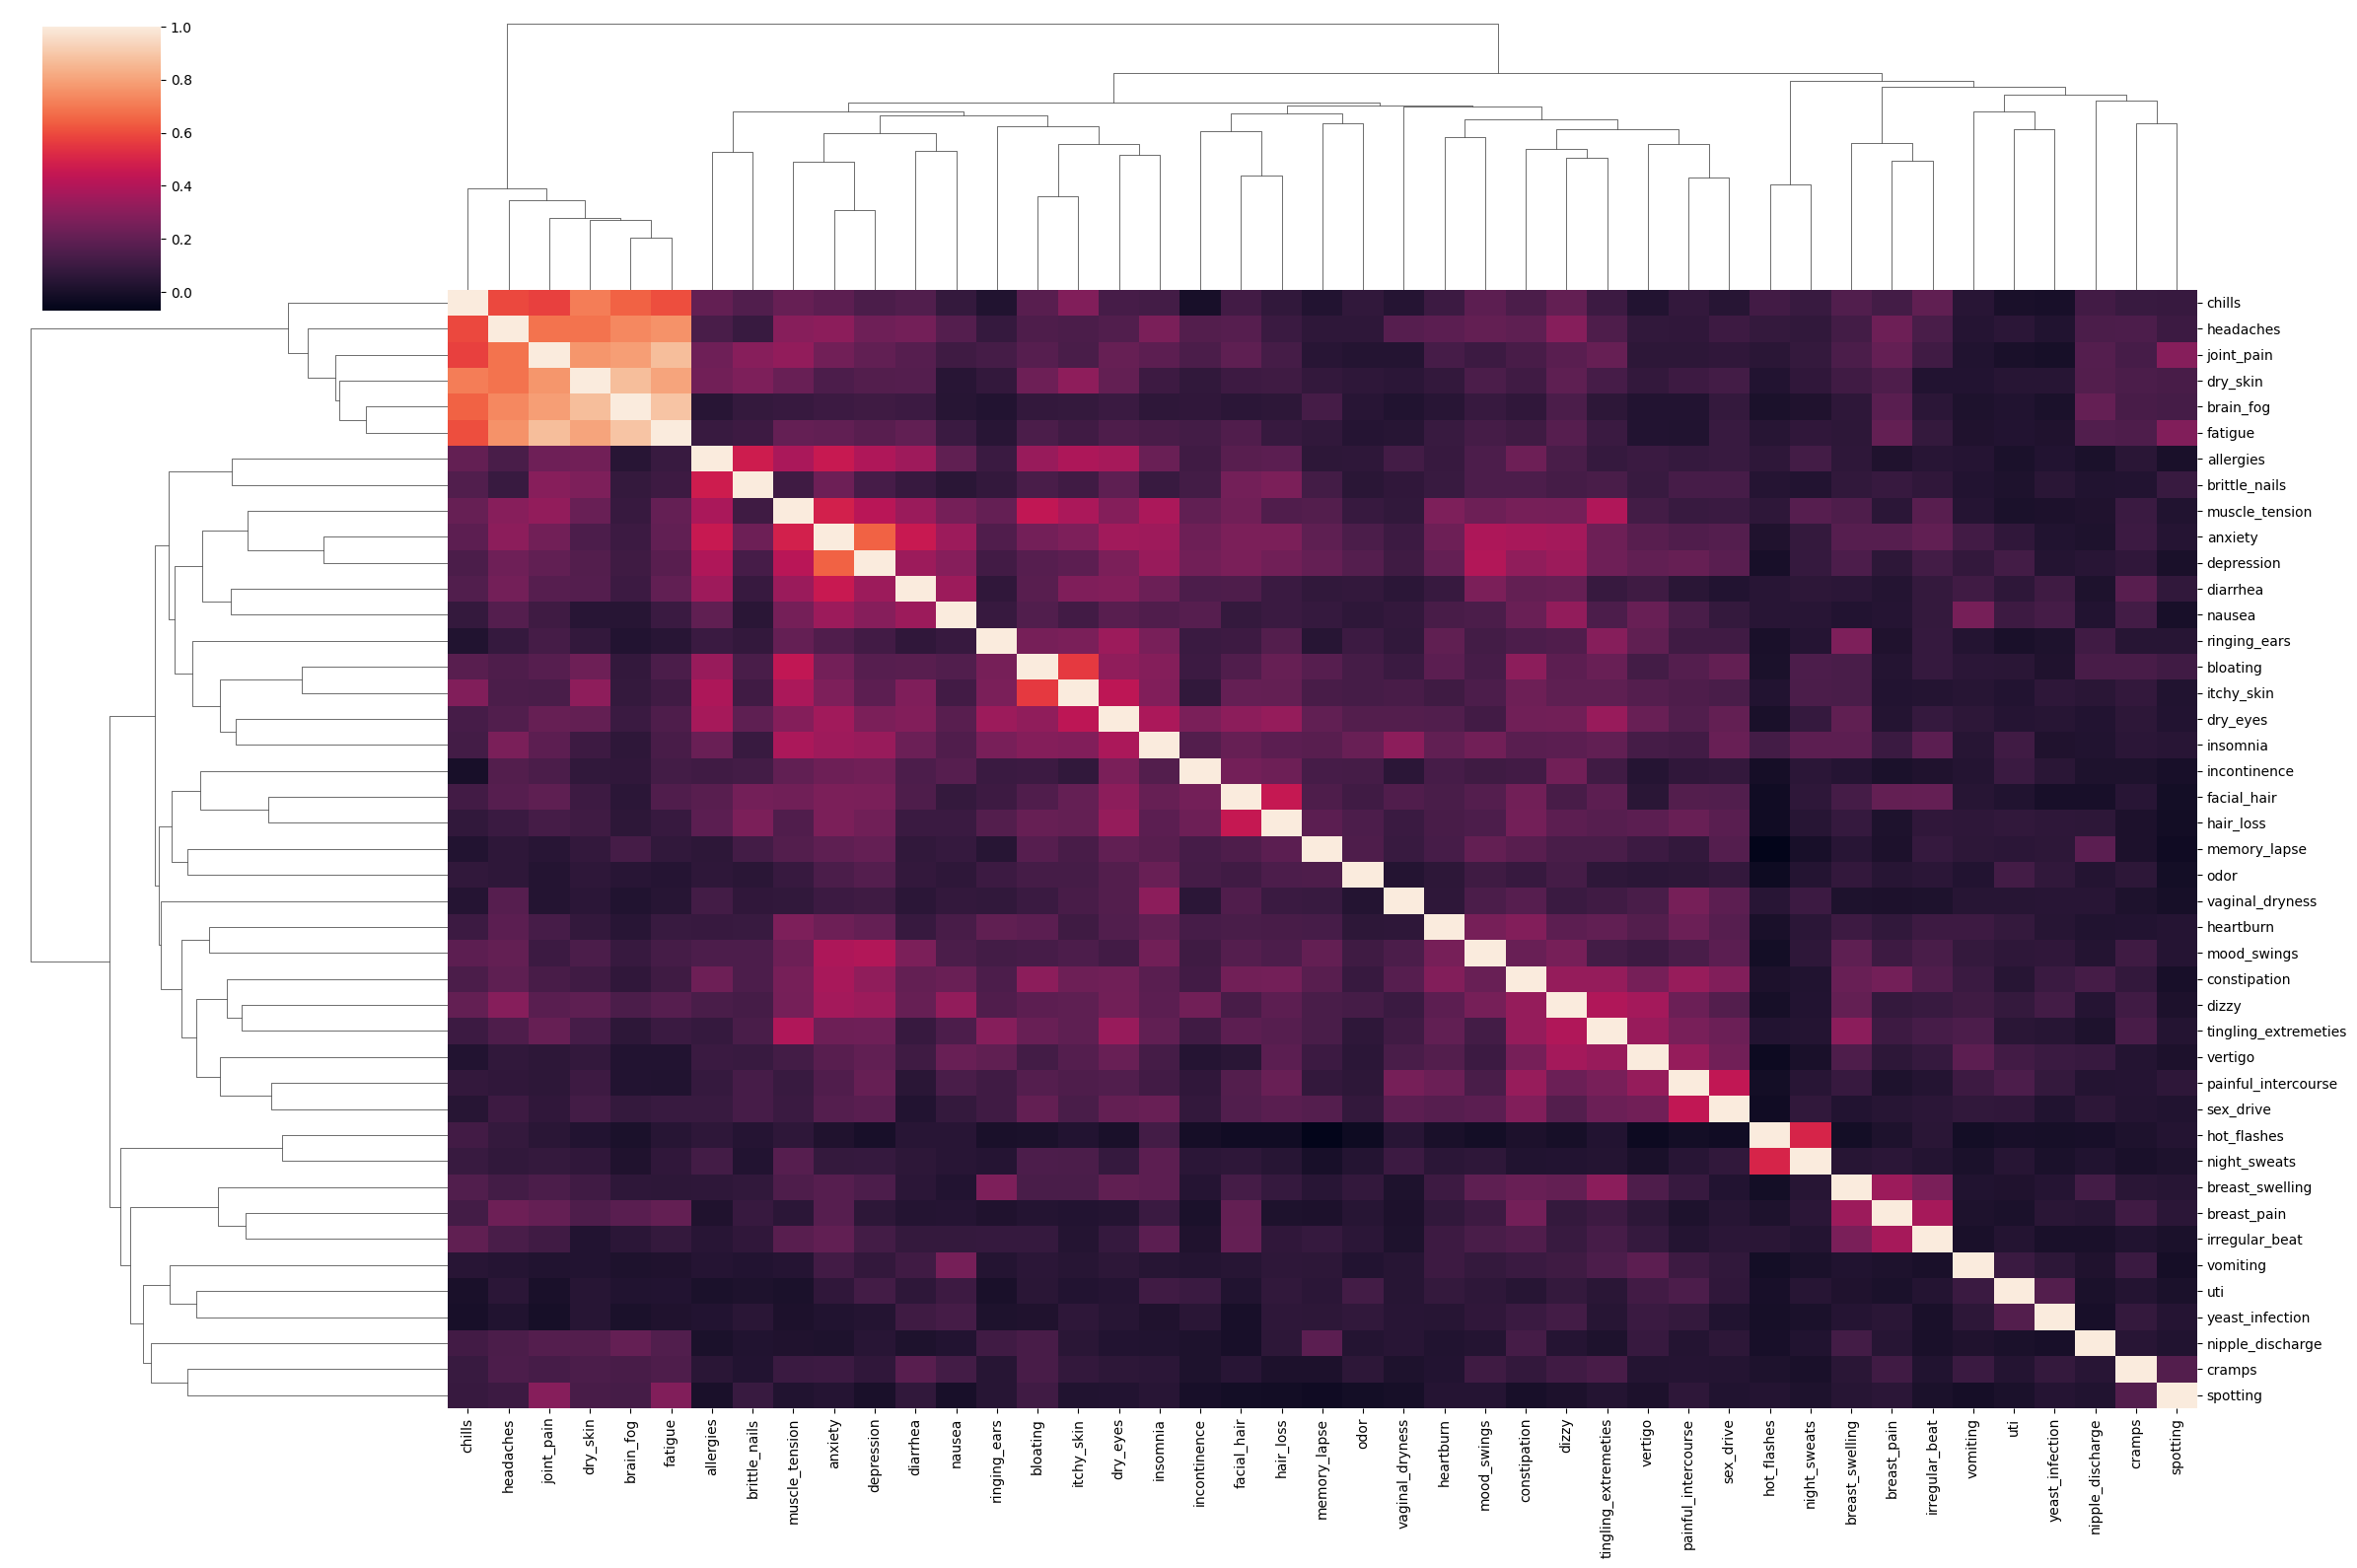

In [ ]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [ ]:
hcluster.savefig('figures/symptom_co_hirach_menopausal.png')

In [ ]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [ ]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 2


## Perform PCA analysis on the data.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [ ]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [ ]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [ ]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.74, 0.74
PCA2 - 0.12, 0.86
PCA3 - 0.04, 0.90
PCA4 - 0.03, 0.93
PCA5 - 0.01, 0.94
PCA6 - 0.01, 0.95
PCA7 - 0.01, 0.95
PCA8 - 0.01, 0.96
PCA9 - 0.00, 0.96
PCA10 - 0.00, 0.97
PCA11 - 0.00, 0.97
PCA12 - 0.00, 0.97
PCA13 - 0.00, 0.97
PCA14 - 0.00, 0.98
PCA15 - 0.00, 0.98


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (96%).

In [ ]:
pcacomponents = pca.fit_transform(X)

In [ ]:
pcacomponents.shape

(3469, 15)

In [ ]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

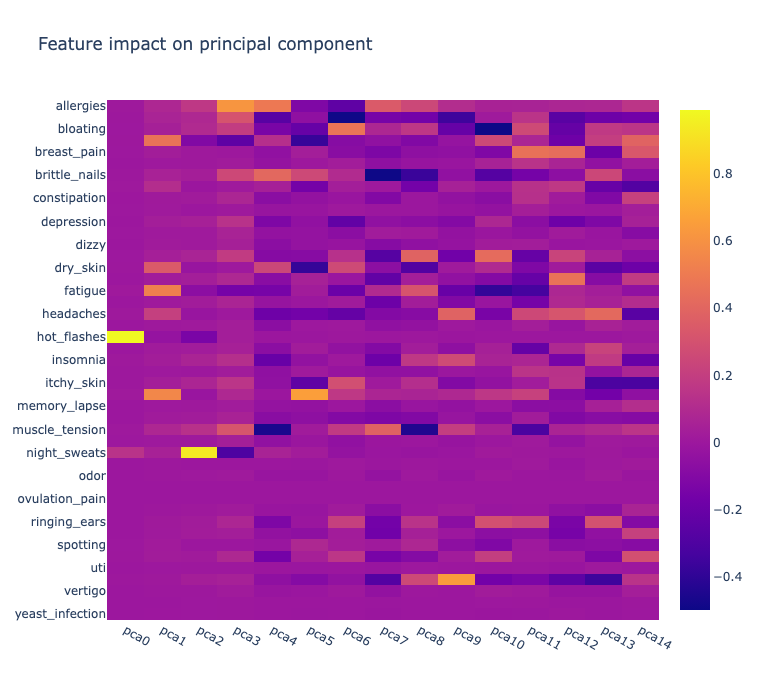

In [ ]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

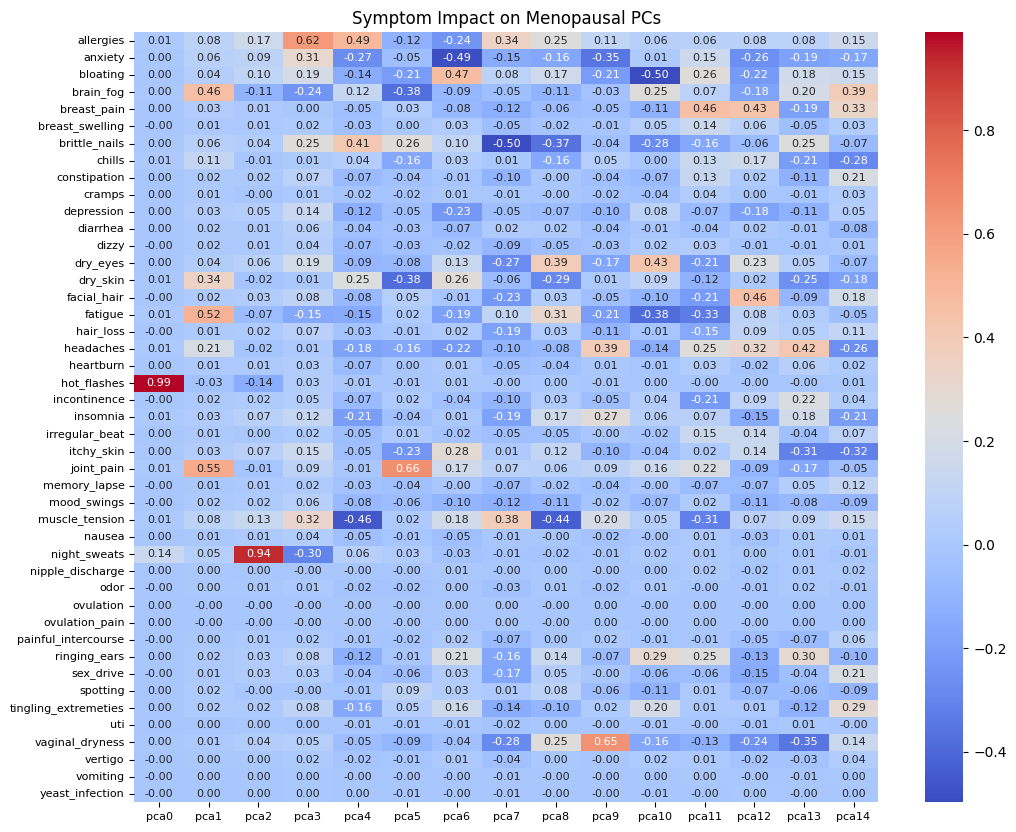

In [ ]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 80% variance

In [ ]:
pca = PCA(n_components=4, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(3469, 4)

In [ ]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

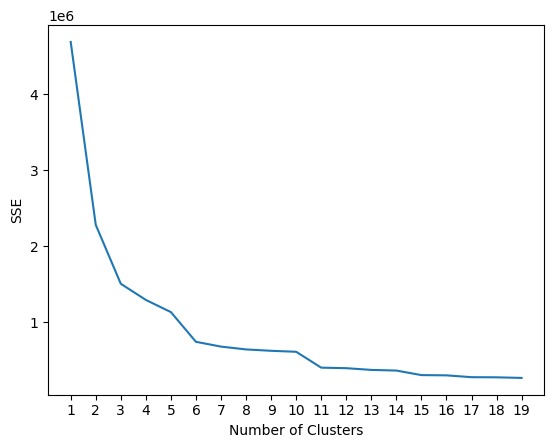

In [ ]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

6

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **6**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

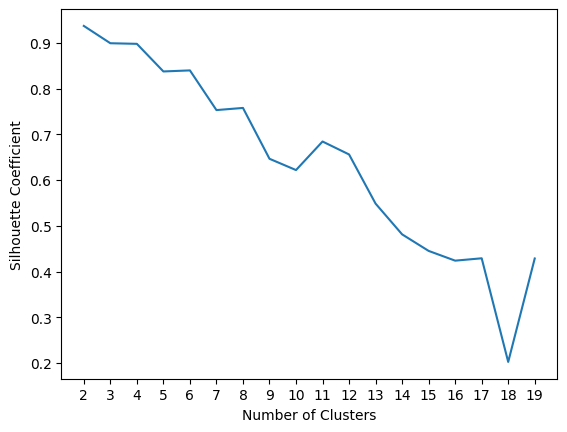

In [ ]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [ ]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 1
1 - 226
2 - 37
3 - 3102
4 - 13
5 - 71
6 - 19


## Get the users which belong to each of these clusters

In [ ]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [ ]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [ ]:
## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [ ]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['brain_fog' 'fatigue' 'joint_pain' 'dry_skin' 'headaches']
Segment 1
['hot_flashes' 'night_sweats' 'fatigue' 'joint_pain' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'headaches' 'vaginal_dryness' 'insomnia']
Segment 3
['hot_flashes' 'fatigue' 'bloating' 'anxiety' 'joint_pain']
Segment 4
['allergies' 'joint_pain' 'hot_flashes' 'muscle_tension' 'anxiety']
Segment 5
['hot_flashes' 'night_sweats' 'fatigue' 'chills' 'joint_pain']
Segment 6
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 20
1 - 3335
2 - 114
Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']
Segment 1
['hot_flashes' 'fatigue' 'joint_pain' 'bloating' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'joint_pain' 'fatigue' 'allergies']
